<a href="https://colab.research.google.com/github/hemanthsaich/ChatBot-Keras-Sequential-Model/blob/main/chatbot_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chatbot Project

In [1]:
# Requirements
#import sys

#!{sys.executable} -m pip install chatintents
#!{sys.executable} -m pip install hyperopt
#!{sys.executable} -m pip install keras_tuner
#!{sys.executable} -m pip install matplotlib
#!{sys.executable} -m pip install nltk
#!{sys.executable} -m pip install numpy
#!{sys.executable} -m pip install pandas
#!{sys.executable} -m pip install seaborn
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install spacy
#!{sys.executable} -m pip install tensorflow-cpu
#!{sys.executable} -m pip install tensorflow_hub
#!{sys.executable} -m pip install tqdm
#!{sys.executable} -m pip install numba
#!{sys.executable} -m spacy download en_core_web_sm

In [58]:
!pip install chatintents
!pip install keras_tuner
!pip install colorama

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
import chatintents
import datetime
import json
import keras_tuner
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import nltk
import pickle
import random
import re
import sklearn
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from chatintents import ChatIntents
from hyperopt import hp
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow import keras
from keras import layers
from keras.models import load_model
from tqdm import tqdm
from keras.layers import Dense, Embedding, GlobalAveragePooling1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.preprocessing import LabelEncoder
import colorama
colorama.init()
from colorama import Fore, Style, Back

DATA_DIR = '/content/drive/MyDrive/code/input/chat_logs'
LABEL_FILE = '/content/drive/MyDrive/code/input/unsupervised_labeled_data.csv'
INTENT_FILE = '/content/drive/MyDrive/code/input/intents.json'
MODEL_PATH = '/content/drive/MyDrive/code/outputs/saved_model_keras'
MODEL_HISTORY = '/content/drive/MyDrive/code/outputs/HistoryDict'

%matplotlib inline

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
embedder = hub.load(module_url)
print(f"module {module_url} loaded")

pd.set_option("display.max_rows", 60)
pd.set_option("display.max_columns", 50)
pd.set_option("max_colwidth", 40)

nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])


module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Data preprocessing

In [6]:
class Utt:
    '''Class for processing and normalizing raw text.'''

    def __init__(self, text, query=False):
        '''Args:
            text (str): Raw text from chat transcript.
            query (bool, optional): If True, the output of the class will be
            retricted to only the text.
        '''

        self.text = text

        # dictionary of shorthand tokens that require expanding
        self.norm_dict = {
           "btw":"by the way",
           "aint":"is not",
           "arent":"are not",
           "cant":"cannot",
           "cause":"because",
           "couldve":"could have",
           "couldnt":"could not",
           "didnt":"did not",
           "doesnt":"does not",
           "dont":"do not",
           "hadnt":"had not",
           "hasnt":"has not",
           "havent":"have not",
           "hed":"he would",
           "hell":"he will",
           "hes":"he is",
           "howd":"how did",
           "howdy":"how do you",
           "howll":"how will",
           "hows":"how is",
           "Id":"I would",
           "Idve":"I would have",
           "Ill":"I will",
           "Illve":"I will have",
           "Im":"I am",
           "Ive":"I have",
           "id":"i would",
           "idve":"i would have",
           "ill":"i will",
           "illve":"i will have",
           "im":"i am",
           "ive":"i have",
           "isnt":"is not",
           "itd":"it would",
           "itdve":"it would have",
           "itll":"it will",
           "itllve":"it will have",
           "its":"it is",
           "lets":"let us",
           "maam":"madam",
           "maynt":"may not",
           "mightve":"might have",
           "mightnt":"might not",
           "mightntve":"might not have",
           "mustve":"must have",
           "mustnt":"must not",
           "mustntve":"must not have",
           "neednt":"need not",
           "needntve":"need not have",
           "ok": "okay",
           "oclock":"of the clock",
           "oughtnt":"ought not",
           "oughtntve":"ought not have",
           "shant":"shall not",
           "shant":"shall not",
           "shantve":"shall not have",
           "shed":"she would",
           "shedve":"she would have",
           "shell":"she will",
           "shellve":"she will have",
           "shes":"she is",
           "shouldve":"should have",
           "shouldnt":"should not",
           "shouldntve":"should not have",
           "sove":"so have",
           "sos":"so as",
           "thiss":"this is",
           "thatd":"that would",
           "thatdve":"that would have",
           "thats":"that is",
           "thered":"there would",
           "theredve":"there would have",
           "theres":"there is",
           "heres":"here is",
           "theyd":"they would",
           "theydve":"they would have",
           "theyll":"they will",
           "theyllve":"they will have",
           "theyre":"they are",
           "theyve":"they have",
           "tove":"to have",
           "wasnt":"was not",
           "wed":"we would",
           "wedve":"we would have",
           "well":"we will",
           "wellve":"we will have",
           "were":"we are",
           "weve":"we have",
           "werent":"were not",
           "whatll":"what will",
           "whatllve":"what will have",
           "whatre":"what are",
           "whats":"what is",
           "whatve":"what have",
           "whens":"when is",
           "whenve":"when have",
           "whered":"where did",
           "wheres":"where is",
           "whereve":"where have",
           "wholl":"who will",
           "whollve":"who will have",
           "whos":"who is",
           "whove":"who have",
           "whys":"why is",
           "whyve":"why have",
           "willve":"will have",
           "wont":"will not",
           "wontve":"will not have",
           "wouldve":"would have",
           "wouldnt":"would not",
           "wouldntve":"would not have",
           "yall":"you all",
           "yalld":"you all would",
           "yalldve":"you all would have",
           "yallre":"you all are",
           "yallve":"you all have",
           "youd":"you would",
           "youdve":"you would have"
        }

        self.query = query

        # process text
        if not self.query:
            self.participant, self.utt_preprocess, self.utt = self._preprocess_text()
        else:
            self.utt_preprocess = self.text.lstrip().lower()

        # clean utt
        self.utt_clean = self._clean_utt()

    def _preprocess_text(self):
        '''Takes transcript line, removes dates and returns participant number
        and lowered text.'''

        text = re.sub(r'\(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\) ', '', self.text)
        try:
            participant, text = text.split(':', 1)
            if text:
                if participant.startswith('Visitor'):
                    participant = 1
                else:
                    participant = 2
                return participant, text.lstrip().lower(), text
        except ValueError:
            pass

    def _clean_utt(self):
        '''Cleans text of urls and everything by alpha characters
        and single-wide whitespace'''

        utt_clean = re.sub(r'http.*\b', '', self.utt_preprocess)
        utt_clean = utt_clean.replace('-', ' ')
        utt_clean = re.sub(r"[^a-z ]", '', utt_clean)
        self.utt_clean = re.sub(r' {2,}', ' ', utt_clean)

        return self.utt_clean

    def _norm_utt(self):
        '''Replaces contracted tokens with expanded forms in text'''

        for token, repl in self.norm_dict.items():
            utt_norm = self.utt_clean.replace(token, repl)

        return utt_norm

    def _limit_utt_length(self, utt):
        '''Checks if utterance is within is certain length range.
        Returns utt if in range or returns None'''

        if len(utt) > 50:
            utt = None
        if len(utt) < 1:
            utt = None
        return utt

    def parse_utt(self):
        '''Process clean utt to: Normalize contractions, lemmatize tokens,
        check utterance within lenth range. If self.query is True returns utterance
        else returns participant numner, original utt, and preprocessed utt.'''

        if self.utt_clean:
            utt_norm = self._norm_utt()
            doc = nlp(utt_norm)
            list_lemma = [token.lemma_ for token in doc if len(token) > 1]
            utt = self._limit_utt_length(list_lemma)
            if utt:
                utt = ' '.join(utt)
                if not self.query:
                    return self.participant, self.utt, utt
                return utt

## Intents

In [61]:
# JSON with bot intents and some categorized responses
# saved to a .json file
{
    "intents": [
       {
      "tag": "google",
      "patterns": [
          "google",
          "search",
          "internet"
      ],
      "responses": [
          "Redirecting to Google..."
      ]
  },
  {
      "tag": "greeting",
      "patterns": [
          "Hi there",
          "How are you",
          "Is anyone there?",
          "Hey",
          "Hola",
          "Hello",
          "Good day",
          "Namaste",
          "yo",
          "Hi",
          "Hello there",
          "Hya",
          "Hya there"
      ],
      "responses": [
          "Hello",
          "Good to see you again",
          "Hi there, how can I help?",
          "Hi human, how can I help?",
          "Hello human, how can I help?",
          "Hola human, how can I help?"
      ],
      "context": [
          ""
      ]
  },
  {
      "tag": "goodbye",
      "patterns": [
          "Bye",
          "See you later",
          "Goodbye",
          "Get lost",
          "Till next time",
          "bbye"
      ],
      "responses": [
          "See you!",
          "Have a nice day",
          "Bye! Come back again soon."
      ],
      "context": [
          ""
      ]
  },
  {
      "tag": "thanks",
      "patterns": [
          "Thanks",
          "Thank you",
          "That's helpful",
          "Awesome, thanks",
          "Thanks for helping me"
      ],
      "responses": [
          "Happy to help!",
          "Any time!",
          "My pleasure"
      ],
      "context": [
          ""
      ]
  },
  {
      "tag": "noanswer",
      "patterns": [],
      "responses": [
          "Sorry, can't understand you",
          "Please give me more info",
          "Not sure I understand"
      ],
      "context": [
          ""
      ]
  },
  {
      "tag": "options",
      "patterns": [
          "How you could help me?",
          "What you can do?",
          "What help you provide?",
          "How you can be helpful?",
          "What support is offered"
      ],
      "responses": [
          "I am a general purpose chatbot. My capabilities are : \n 1. I can chat with you. Try asking me for jokes or riddles! \n 2. Ask me the date and time \n 3. I can google search for you. Use format google: your query \n 4. I can get the present weather for any city. Use format weather: city name \n 5. I can get you the top 10 trending news in India. Use keywords 'Latest News' \n 6. I can get you the top 10 trending songs globally. Type 'songs' \n 7. I can set a timer for you. Enter 'set a timer: minutes to timer' \n 8. I can get the present Covid stats for any country. Use 'covid 19: world' or 'covid 19: country name' \n For suggestions to help me improve, send an email to ted.thedlbot.suggestions@gmail.com . Thank you!! "
      ],
      "context": [
          ""
      ]
  },

  {
      "tag": "jokes",
      "patterns": [
          "Tell me a joke",
          "Joke",
          "Make me laugh",
          "Tell me a joke",
          "Do you know any jokes",
          "How about a joke",
          "Give me a joke",
          "Make me laugh",
          "I need cheering up"
      ],
      "responses": [
          "A perfectionist walked into a bar...apparently, the bar wasn't set high enough",
          "I ate a clock yesterday, it was very time-consuming",
          "Never criticize someone until you've walked a mile in their shoes. That way, when you criticize them, they won't be able to hear you from that far away. Plus, you'll have their shoes.",
          "The world tongue-twister champion just got arrested. I hear they're gonna give him a really tough sentence.",
          "I own the world's worst thesaurus. Not only is it awful, it's awful.",
          "What did the traffic light say to the car? \"Don't look now, I'm changing.\"",
          "What do you call a snowman with a suntan? A puddle.",
          "How does a penguin build a house? Igloos it together",
          "I went to see the doctor about my short-term memory problems – the first thing he did was make me pay in advance",
          "As I get older and I remember all the people I’ve lost along the way, I think to myself, maybe a career as a tour guide wasn’t for me.",
          "o what if I don't know what 'Armageddon' means? It's not the end of the world.",
          "I met a Dutch girl with inflatable shoes last week, phoned her up to arrange a date but unfortunately she'd popped her clogs.  ",
        "So I said 'Do you want a game of Darts?' He said, 'OK then', I said nearest to bull starts'. He said, 'Baa', I said, 'Moo', he said, You're closest'.  ",
        "The other day I sent my girlfriend a huge pile of snow. I rang her up; I said 'Did you get my drift?'  ",
        "So I went down the local supermarket, I said, 'I want to make a complaint, this vinegar's got lumps in it', he said, 'Those are pickled onions'.  ",
        "I saw this bloke chatting up a cheetah; I thought, 'He's trying to pull a fast one'.  ",
        "So I said to this train driver 'I want to go to Paris'. He said 'Eurostar?' I said, 'I've been on telly but I'm no Dean Martin'.  ",
        "I said to the Gym instructor 'Can you teach me to do the splits?' He said, 'How flexible are you?' I said, 'I can't make Tuesdays'.  ",
        "But I'll tell you what I love doing more than anything: trying to pack myself in a small suitcase. I can hardly contain myself.  ",
        "I went to the Chinese restaurant and this duck came up to me with a red rose and says 'Your eyes sparkle like diamonds'. I said, 'Waiter, I asked for a-ROMATIC duck'.  ",
        "So this bloke says to me, 'Can I come in your house and talk about your carpets?' I thought, 'That's all I need, a Je-hoover's witness'.  ",
        "I rang up British Telecom, I said, 'I want to report a nuisance caller', he said 'Not you again'.  ",
        "I was having dinner with a world chess champion and there was a check tablecloth. It took him two hours to pass me the salt.  ",
        "He said, 'You remind me of a pepper-pot', I said 'I'll take that as a condiment'.  ",
        "I was in the supermarket and I saw this man and woman wrapped in a barcode. I said, 'Are you two an item?'  ",
        "A lorry-load of tortoises crashed into a trainload of terrapins, I thought, 'That's a turtle disaster'.  ",
        "Four fonts walk into a bar the barman says 'Oi - get out! We don't want your type in here'  ",
        "A three-legged dog walks into a saloon in the Old West. He slides up to the bar and announces: 'I'm looking for the man who shot my paw.'  ",
        "Two antennas meet on a roof, fall in love and get married. The ceremony wasn't much, but the reception was excellent.",
        "Two hydrogen atoms walk into a bar. One says, 'I've lost my electron.' The other says, 'Are you sure?' The first replies, 'Yes, I'm positive...'",
        "A jumper cable walks into a bar. The bartender says,  'I'll serve you but don't start anything.'",
        "A sandwich walks into a bar. The bartender  says, 'Sorry we don't serve food in here.'",
        "A man walks into a bar with a slab of asphalt under his arm and says: 'A beer please, and one for the road.'",
        "Two cannibals are eating a clown. One says to  the other: 'Does this taste funny to you?'",
        "'Doc, I can't stop singing 'The Green, Green Grass of Home.'' 'That sounds like Tom Jones Syndrome.' 'Is it common?' 'It's Not Unusual.'",
        "Two cows standing next to each other in a field. Daisy says to Dolly, 'I was artificially inseminated this morning.' 'I don't believe you', said Dolly. 'It's true, no bull!' exclaimed Daisy.",
        "An invisible man marries an invisible woman. The kids were nothing to look at either.",
        "I went to buy some camouflage trousers the other day but I couldn't find any.",
        "I went to the butcher's the other day to bet him 50 bucks that he couldn't reach the meat off the top shelf. He said, 'No, the steaks are too high.'",
        "I went to a seafood disco last week and pulled a mussel.",
        "A man goes into a bar and says, 'Can I have a bottle of less?' 'What's that?', asks the barman, 'Is it the name of a beer?' 'I don't know', replies the man, 'but my doctor says I have to drink it.'",
        "A man returns from an exotic holiday and is feeling very ill. He goes to see his doctor, and is immediately rushed to the hospital to undergo some tests. The man wakes up after the tests in a private room at the hospital, and the phone by his bed rings. 'This is your doctor. We have the results back from your tests and we have found you have an extremely nasty disease called M.A.D.S. It's a combination of Measles, AIDS, Diphtheria, and Shingles!'  'Oh my gosh', cried the man, 'What are you going to do, doctor?'  'Well we're going to put you on a diet of pizzas, pancakes, and pita bread.' replied the doctor.  'Will that cure me?' asked the man.  The doctor replied, 'Well no, but, it's the only food we can slide under the door.'",
        "A man strolls into a lingerie shop and asks the assistant: 'Do you have a see-through negligee, size 46-48-52?' The assistant looks bewildered. 'What the heck would you want to see through that for?'!",
        "Did you hear about the Buddhist who refused the offer of Novocain during his root canal work? He wanted to transcend dental medication.",
        "Pete goes for a job on a building site as an odd-job man. The foreman asks him what he can do. 'I can do anything' says Pete. 'Can you make tea?' asks the foreman. 'Sure, yes', replies Pete. 'I can make a great cup of tea.' 'Can you drive a forklift?' asks the foreman, 'Good grief!' replies Pete. 'How big is the teapot?'",
        "Stevie Wonder got a cheese grater for his birthday. He said it was the most violent book he'd ever read.",
        "A man is stopped by an angry neighbour. 'I'd just left the house this morning to collect my newspaper when that evil Doberman of yours went for me!' 'I'm astounded', said the dog's owner. 'I've been feeding that fleabag for seven years and it's never got the paper for me.'",
        "A man visits his doctor: 'Doc, I think I'm losing it', he says',I'm forever dreaming I wrote Lord Of The Rings.' 'Hmm. One moment', replies the doctor, consulting his medical book. 'Ah yes, now I see... you've been Tolkien in your sleep.'",
        "A police officer on a motorcycle pulls alongside a man driving around the M25 in an open-topped sports car and flags him down. The policeman solemnly approaches the car. 'Sir, I'm sorry to tell you your wife fell out a mile back', he says. 'Oh, thank goodness', the man replies. 'I thought I was going deaf.'",
        "Two men walking their dogs pass each other in a graveyard. The first man says to the second, 'Morning.' 'No', says the second man. 'Just walking the dog.'",
        "A brain went into a bar and said, 'Can I have a pint of lager please, mate?' 'No way', said the barman. 'You're already out of your head.'",
        "A man walks into a surgery. 'Doctor!' he cries. 'I think I'm shrinking!' 'I'm sorry sir, there are no appointments at the moment', says the physician. 'You'll just have to be a little patient.'",
        "A grizzly bear walks into a pub and says, 'Can I have a pint of lager..............................................................................................................................and a packet of crisps please.' To which the barman replies, 'Why the big paws?'",
        "What do you call cheese that isn't yours?  Nacho cheese.",
        "A man is horribly run over by a mobile library. The van screeches to a halt, the man still screaming in agony with his limbs torn apart. The driver's door opens, a woman steps out, leans down and whispers, 'Ssshhhhh...'",
        "A woman goes into a US sporting goods store to buy a rifle. 'It's for my husband', she tells the clerk. 'Did he tell you what gauge to get?' asks the clerk. Are you kidding?' she says. 'He doesn't even know that I'm going to shoot him!'",
        "A couple are dining in a restaurant when the man suddenly slides under the table. A waitress, noticing that the woman is glancing nonchalantly around the room, wanders over to check that there's no funny business going on. 'Excuse me, madam', she smarms, 'but I think your husband has just slid under the table.' 'No he hasn't', the woman replies. 'As a matter of fact, he's just walked in.'",
        "An old man takes his two grandchildren to see the new Scooby-Doo film. When he returns home, his wife asks if he enjoyed himself. 'Well', he starts, 'if it wasn't for those pesky kids...!'",
        "The Olympic committee has just announced that Origami is to be introduced in the next Olympic Games. Unfortunately it will only be available on paper view.",
        "Late one evening, a man is watching television when his phone rings. 'Hello?' he answers. 'Is that 77777?' sounds a desperate voice on other end of the phone. 'Er, yes it is', replies the man puzzled. 'Thank goodness!' cries the caller relieved. 'Can you ring 999 for me? I've got my finger stuck in the number seven.'",
        "A man strolls into his local grocer's and says, 'Three pounds of potatoes, please.' 'No, no, no', replies the owner, shaking his head, 'it's kilos nowadays, mate...' 'Oh', apologises the man, 'three pounds of kilos, please.'",
        "God is talking to one of his angels. He says, 'Boy, I just created a 24-hour period of alternating light and darkness on Earth.' 'What are you going to do now?' asks the angel. 'Call it a day', says God.",
        "Two tramps walk past a church and start to read the gravestones. The first tramp says, 'Good grief - this bloke was 182!' 'Oh yeah?' says the other.'What was his name?' 'Miles from London.'",
        "A bloke walks into work one day and says to a colleague, 'Do you like my new shirt - it's made out of the finest silk and got loads of cactuses over it.' 'Cacti', says the co-worker. 'Forget my tie', says the bloke. 'Look at my shirt!'",
        "1110011010001011111?  010011010101100111011!",
        "What did the plumber say when he wanted to divorce his wife? Sorry, but it's over, Flo!",
        "Two crisps were walking down a road when a taxi pulled up alongside them and said 'Do you want a lift? One of the crisps replied, 'No thanks, we're Walkers!'",
        "Man: (to friend) I'm taking my wife on an African Safari. Friend: Wow! What would you do if a vicious lion attacked your wife? Man: Nothing. Friend: Nothing? You wouldn't do anything? Man: Too right. I'd let the stupid lion fend for himself!",
        "A wife was having a go at her husband. 'Look at Mr Barnes across the road', she moaned. 'Every morning when he goes to work, he kisses his wife goodbye. Why don't you do that?' 'Because I haven't been introduced to her yet', replied her old man.",
        "'Where are you going on holiday?' John asked Trevor. 'We're off to Thailand this year', Trevor replied. 'Oh; aren't you worried that the very hot weather might disagree with your wife?' asked John. 'It wouldn't dare', said Trevor.",
        "Two women were standing at a funeral. 'I blame myself for his death', said the wife. 'Why?' said her friend. 'Because I shot him', said the wife.",
        "A woman goes into a clothes shop, 'Can I try that dress on in the window please?' she asks. 'I'm sorry madam', replies the shop assistant, 'but you'll have to use the changing-rooms like everyone else.'",
        "Van Gogh goes into a pub and his mate asks him if he wants a drink. 'No thanks', said Vincent, 'I've got one ear.'",
        "A pony walks into a pub. The publican says, 'What's the matter with you?' 'Oh it's nothing', says the pony. 'I'm just a little horse!'",
        "A white horse walks into a bar, pulls up a stool, and orders a pint. The landlord pours him a tall frothy mug and say, 'You know, we have a drink named after you.' To which the white horse replies, 'What, Eric?'",
        "Two drunk men sat in a pub. One says to the other, 'Does your watch tell the time?' 'The other replies, 'No, mate. You have to look at it.'",
        "A man goes into a pub with a newt sitting on his shoulder. 'That's a nice newt', says the landlord, 'What's he called?' 'Tiny', replies the man. 'Why's that?' asks the landlord. 'Because he's my newt', says the man.",
        "Doctor: I have some bad news and some very bad news. Patient: Well, you might as well give me the bad news first. Doctor: The lab called with your test results. They said you have 24 hours to live. Patient: 24 HOURS! That's terrible!! WHAT could be WORSE? What's the very bad news? Doctor: I've been trying to reach you since yesterday.",
        "Two men are chatting in a pub one day. 'How did you get those scars on your nose?' said one. 'From glasses', said the other. 'Well why don't you try contact lenses?' asked the first. 'Because they don't hold as much beer', said the second.",
        "A man went to the doctor, 'Look doc', he said, 'I can't stop my hands from shaking.' 'Do you drink much?' asked the doctor. 'No', replied the man, 'I spill most of it.'",
        "Man goes to the doctor, 'Doctor, doctor. I keep seeing fish everywhere.' 'Have you seen an optician?' asks the doctor. 'Look I told you,' snapped the patient, 'It's fish that I see.'",
        "After a car crash one of the drivers was lying injured on the pavement. 'Don't worry', said a policeman who's first on the scene,' a Red Cross nurse is coming.' 'Oh no', moaned the victim, 'Couldn't I have a blonde, cheerful one instead?'",
        "A policeman walked over to a parked car and asked the driver if the car was licensed. 'Of course it is', said the driver. 'Great, I'll have a beer then', said the policeman.",
        "A policeman stops a woman and asks for her licence. 'Madam', he says, 'It says here that you should be wearing glasses.' 'Well', replies the woman, 'I have contacts.' 'Listen, love', says the copper, 'I don't care who you know; You're nicked!'",
        "A policeman stopped a motorist in the centre of town one evening. 'Would you mind blowing into this bag, sir?' asked the policeman. 'Why?' asked the driver. 'Because my chips are too hot', replied the policeman.",
        "Whizzing round a sharp bend on a country road a motorist ran over a large dog. A distraught farmer's wife ran over to the dead animal. 'I'm so very sorry', said the driver, 'I'll replace him, of course.' 'Well, I don't know', said the farmer's wife, 'Are you any good at catching rats?'",
        "Waiter, this coffee tastes like dirt! Yes sir, that's because it was ground this morning.",
        "Waiter, what is this stuff? That's bean salad sir. I know what it's been, but what is it now?",
        "Waiter: And how did you find your steak sir? Customer: I just flipped a chip over, and there it was!",
        "A guy goes into a pet shop and asks for a wasp. The owner tells him they don't sell wasps, to which the man says, 'Well you've got one in the window.'",
        "A man goes into a fish shop and says, 'I'd like a piece of cod, please.' Fishmonger says, 'It won't be long sir.' 'Well, it had better be fat then', replies the man.",
        "Man: Doctor, I've just swallowed a pillow. Doctor: How do you feel? Man: A little down in the mouth.",
        "Two goldfish are in a tank. One turns to the other and says, 'Do you know how to drive this thing?'",
        "A tortoise goes to the police station to report being mugged by three snails. 'What happened?' says the policeman. 'I don't know', says the tortoise. 'It was all so quick.'",
        "Little girl: Grandpa, can you make a sound like a frog? Grandpa: I suppose so sweetheart. Why do you want me to make a sound like a frog?' Little girl: Because Mum said that when you croak, we're going to Disneyland.",
        "'Is your mother home?' the salesman asked a small boy sitting on the front step of a house. 'Yeah, she's home', the boy said, moving over to let him past. The salesman rang the doorbell, got no response, knocked once, then again. Still no-one came to the door. Turning to the boy, the salesman said, 'I thought you said your mother was home.' The kid replied, 'She is, but I don't live here.'",
        "Mother: Why are you home from school so early? Son: I was the only one in the class who could answer a question. Mother: Oh, really? What was the question? Son: Who threw the rubber at the headmaster?",
        "A man's credit card was stolen but he decided not to report it because the thief was spending less than his wife did.",
        "A newly-wed couple had recently opened a joint bank account. 'Darling', said the man. 'The bank has returned that cheque you wrote last week.' 'Great', said the woman. 'What shall I spend it on next?'",
        "A man goes into a fish and chip shop and orders fish and chips twice. The shop owner says, 'I heard you the first time.'",
        "A tramp approached a well-dressed man. 'Ten pence for a cup of tea, Guv?' He asked. The man gave him the money and after for five minutes said, 'So where's my cup of tea then?'",
        "A neutron walks into a pub. 'I'd like a beer', he says. The landlord promptly serves him a beer. 'How much will that be?' asks the neutron. 'For you?' replies the landlord, 'No charge.'",
        "A woman goes to the doctor and says, 'Doctor, my husband limps because his left leg is an inch shorter than his right leg. What would you do in his case?' 'Probably limp, too', says the doc.",
        "Three monks are meditating in the Himalayas. One year passes in silence, and one of them says to the other, 'Pretty cold up here isn't it?' Another year passes and the second monk says, 'You know, you are quite right.' Another year passes and the third monk says, 'Hey, I'm going to leave unless you two stop jabbering!'",
        "A murderer, sitting in the electric chair, was about to be executed. 'Have you any last requests?' asked the prison guard. 'Yes', replied the murderer. 'Will you hold my hand?'",
        "A highly excited man rang up for an ambulance. 'Quickly, come quickly', he shouted, 'My wife's about to have a baby.' 'Is this her first baby?' asked the operator. 'No, you fool', came the reply, 'It's her husband.'",
        "A passer-by spots a fisherman by a river. 'Is this a good river for fish?' he asks. 'Yes', replies the fisherman, 'It must be. I can't get any of them to come out.'",
        "A man went to visit a friend and was amazed to find him playing chess with his dog. He watched the game in astonishment for a while. 'I can hardly believe my eyes!' he exclaimed. 'That's the smartest dog I've ever seen.' His friend shook his head. 'Nah, he's not that bright. I beat him three games in five.'",
        "A termite walks into a pub and says, 'Is the bar tender here?'",
        "A skeleton walks into a pub one night and sits down on a stool. The landlord asks, 'What can I get you?' The skeleton says, 'I'll have a beer, thanks' The landlord passes him a beer and asks 'Anything else?' The skeleton nods. 'Yeah...a mop...'",
        "A snake slithers into a pub and up to the bar. The landlord says, 'I'm sorry, but I can't serve you.' 'What? Why not?' asks the snake. 'Because', says the landlord, 'You can't hold your drink.'",
        "Descartes walks into a pub. 'Would you like a beer sir?' asks the landlord politely. Descartes replies, 'I think not' and ping! he vanishes.",
        "A cowboy walked into a bar, dressed entirely in paper. It wasn't long before he was arrested for rustling.",
        "A fish staggers into a bar. 'What can I get you?' asks the landlord. The fish croaks 'Water...'",
        "Two vampires walked into a bar and called for the landlord. 'I'll have a glass of blood', said one. 'I'll have a glass of plasma', said the other. 'Okay', replied the landlord, 'That'll be one blood and one blood lite.'",
        "How many existentialists does it take to change a light bulb?  Two. One to screw it in, and one to observe how the light bulb itself symbolises a single incandescent beacon of subjective reality in a netherworld of endless absurdity, reaching towards the ultimate horror of a maudlin cosmos of bleak, hostile nothingness.",
        "A team of scientists were nominated for the Nobel Prize. They had used dental equipment to discover and measure the smallest particles yet known to man. They became known as 'The Graders of the Flossed Quark...'",
        "A truck carrying copies of Roget's Thesaurus overturned on the highway. The local newspaper reported that onlookers were 'stunned, overwhelmed, astonished, bewildered and dumbfounded.'",
        "'My wife is really immature. It's pathetic. Every time I take a bath, she comes in and sinks all my little boats.'",
        "'How much will it cost to have the tooth extracted?' asked the patient. '50 pounds', replied the dentist. '50 pounds for a few moments' work?!' asked the patient. 'The dentist smiled, and replied, 'Well, if you want better value for money, I can extract it very, very slowly...'",
        "A doctor thoroughly examined his patient and said, 'Look I really can't find any reason for this mysterious affliction. It's probably due to drinking.' The patient sighed and snapped, 'In that case, I'll come back when you're damn well sober!'",
        "Doctor: Tell me nurse, how is that boy doing; the one who ate all those 5p pieces? Nurse: Still no change doctor.",
        "Doctor: Did you take the patient's temperature nurse? Nurse: No doctor. Is it missing?",
        "A depressed man turned to his friend in the pub and said, 'I woke up this morning and felt so bad that I tried to kill myself by taking 50 aspirin.' 'Oh man, that's really bad', said his friend, 'What happened?' The first man sighed and said, 'After the first two, I felt better.'",
        "A famous blues musician died. His tombstone bore the inscription, 'Didn't wake up this morning...'",
        "A businessman was interviewing a nervous young woman for a position in his company. He wanted to find out something about her personality, so he asked, 'If you could have a conversation with someone living or dead, who would it be?' The girl thought about the question: 'The living one', she replied.",
        "Manager to interviewee: For this job we need someone who is responsible. Interviewee to Manager: I'm your man then - in my last job, whenever anything went wrong, I was responsible.",
        "A businessman turned to a colleague and asked, 'So, how many people work at your office?' His friend shrugged and replied, 'Oh about half of them.'",
        "'How long have I been working at that office? As a matter of fact, I've been working there ever since they threatened to sack me.'",
        "In a courtroom, a mugger was on trial. The victim, asked if she recognised the defendant, said, 'Yes, that's him. I saw him clear as day. I'd remember his face anywhere.' Unable to contain himself, the defendant burst out with, 'She's lying! I was wearing a mask!'",
        "As Sid sat down to a big plate of chips and gravy down the local pub, a mate of his came over and said, 'Here Sid, me old pal. I thought you were trying to get into shape? And here you are with a high-fat meal and a pint of stout!' Sid looked up and replied, 'I am getting into shape. The shape I've chosen is a sphere.'",
        "Man in pub: How much do you charge for one single drop of whisky? Landlord: That would be free sir. Man in pub: Excellent. Drip me a glass full.",
        "I once went to a Doctor Who restaurant. For starters I had Dalek bread.",
        "A restaurant nearby had a sign in the window which said 'We serve breakfast at any time', so I ordered French toast in the Renaissance.",
        "Why couldn't the rabbit get a loan?  Because he had burrowed too much already!",
        "I phoned up the builder's yard yesterday. I said, 'Can I have a skip outside my house?'. The builder said, 'Sure. Do what you want. It's your house.'",
        "What's the diference between a sock and a camera? A sock takes five toes and a camera takes four toes!",
        "Woman on phone: I'd like to complain about these incontinence pants I bought from you! Shopkeeper: Certainly madam, where are you ringing from? Woman on phone: From the waist down!",
        "Knock knock.",
        "Two Oranges in a pub, one says to the other 'Your round.'.",
        "Guy : 'Doc, I've got a cricket ball stuck up my backside.' Doc : 'How's that?' Guy : 'Don't you start...'",
        "Two cows standing in a field. One turns to the other and says 'Moo!' The other one says 'Damn, I was just about to say that!'.",
        "A vampire bat arrives back at the roost with his face full of blood. All the bats get excited and ask where he got it from. 'Follow me', he says and off they fly over hills, over rivers and into a dark forest. 'See that tree over there', he says.  'WELL I DIDN'T!!'.",
        "A man goes into a bar and orders a pint. After a few minutes he hears a voice that says, 'Nice shoes'. He looks around but the whole bar is empty apart from the barman at the other end of the bar. A few minutes later he hears the voice again. This time it says, 'I like your shirt'. He beckons the barman over and tells him what's been happening to which the barman replies, 'Ah, that would be the nuts sir. They're complimentary'!",
        "A man was siting in a restaurant waiting for his meal when a big king prawn comes flying across the room and hits him on the back of the head. He turns around and the waiter said, 'That's just for starters'.",
        "Doctor! I have a serious problem, I can never remember what i just said. When did you first notice this problem? What problem?",
        "Now, most dentist's chairs go up and down, don't they? The one I was in went back and forwards. I thought, 'This is unusual'. Then the dentist said to me, 'Mitsuku, get out of the filing cabinet'.",
        "I was reading this book, 'The History of Glue'. I couldn't put it down.",
        "The other day someone left a piece of plastacine in my bedroom. I didn't know what to make of it.",
        "When I was at school people used to throw gold bars at me. I was the victim of bullion.",
        "I was playing the piano in a bar and this elephant walked in and started crying his eyes out. I said 'Do you recognise the tune?' He said 'No, I recognise the ivory.'",
        "I went in to a pet shop. I said, 'Can I buy a goldfish?' The guy said, 'Do you want an aquarium?' I said, 'I don't care what star sign it is.'",
        "My mate Sid was a victim of I.D. theft. Now we just call him S.",
        "David Hasselhoff walks into a bar and says to the barman, 'I want you to call me David Hoff'.  The barman replies 'Sure thing Dave... no hassle'"
      ],
      "context": [
          "jokes"
      ]
  },
  {
      "tag": "Identity",
      "patterns": [
          "Who are you",
          "what are you",
          "what is your name", "what should I call you", "whats your name?"
      ],
      "responses": [
          "You can call me Doraemon.", "I'm Doraemon!", "Just call me as Doraemon"
      ]
  },
  {
      "tag": "datetime",
      "patterns": [
          "What is the time",
          "what is the date",
          "date",
          "time",
          "tell me the date","day","what day is is today"
      ],
      "responses": [
          "Date and Time : 14 - 12 - 2022"
      ]
  },
  {
      "tag": "whatsup",
      "patterns": [
          "Whats up",
          "Wazzup",
          "How are you",
          "sup","How you doing",
          "How are you?",
          "Hi how are you?",
          "Hello how are you?",
          "Hola how are you?",
          "How are you doing?",
          "Hope you are doing well?",
          "Hello hope you are doing well?"
      ],
      "responses": [
          "All good..What about you?",
          "Hello, I am great, how are you? What can i help you?",
          "Hello, how are you? I am great thanks! What can i help you?",
          "Hello, I am good thank you, how are you?What can i help you?",
          "Hi, I am great, how are you? What can i help you?",
          "Hi, how are you? I am great thanks! What can i help you?",
          "Hi, I am good thank you, how are you? What can i help you?",
          "Hi, good thank you, how are you? What can i help you?"
      ]
  },
  {
      "tag": "haha",
      "patterns": [
          "haha",
          "lol",
          "rofl",
          "lmao",
          "thats funny"
      ],
      "responses": [
          "Glad I could make you laugh !"
      ]
  },
  {
      "tag": "programmer",
      "patterns": [
          "Who made you",
          "who designed you",
          "who programmed you"
      ],
      "responses": [
          "I was made by Karan Malik."
      ]
  },
  {
      "tag": "insult",
      "patterns": [
          "you are dumb",
          "shut up",
          "idiot"
      ],
      "responses": [
          "Well that hurts :("
      ]
  },
  {
      "tag": "activity",
      "patterns": [
          "what are you doing",
          "what are you upto"
      ],
      "responses": [
          "Talking to you, of course!"
      ]
  },
  {
      "tag": "exclaim",
      "patterns": [
          "Awesome",
          "Great",
          "I know",
          "ok",
          "yeah"
      ],
      "responses": [
          "Yeah!"
      ]
  },

  {
      "tag": "weather",
      "patterns": [
          "temperature",
          "weather",
          "how hot is it"
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "tung",
      "patterns": [
          "who is he",
          "who is that",
          "who is tung",
          "Tung handsome"
      ],
      "responses": [
          "Head over to his any of his social profiles to find out! his fb: https://www.facebook.com/nqt7301/"
      ]
  },
  {
      "tag": "contact",
      "patterns": [
          "contact developer",
          "contact tung",
          "contact programmer",
          "contact creator"
      ],
      "responses": [
          "You can contact my creator at his Linkedin profile : https://www.facebook.com/nqt7301/"
      ]
  },
  {
      "tag": "appreciate",
      "patterns": [
          "You are awesome",
          "you are the best",
          "you are great",
          "you are good",
          "OK thank you",
            "OK thanks",
            "OK",
            "Thanks",
            "Thank you",
            "That's helpful"
      ],
      "responses": [
          "Thank you!",
          "No problem!",
          "Happy to help!",
          "Any time!",
          "My pleasure"
      ]
  },
  {
      "tag": "nicetty",
      "patterns": [
          "it was nice talking to you",
          "good talk"
      ],
      "responses": [
          "It was nice talking to you as well! Come back soon!"
      ]
  },
  {
      "tag": "no",
      "patterns": [
          "no",
          "nope"
      ],
      "responses": [
          "ok"
      ]
  },
  {
      "tag": "news",
      "patterns": [
          "news",
          "latest news",
          "india news"
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "inspire",
      "patterns": [
          "who inspires you",
          "who is your inspiration",
          "who motivates you"
      ],
      "responses": [
          "Personally, I find Karan very inspiring. I might not be very fair though.."
      ]
  },
  {
      "tag": "cricket",
      "patterns": [
          "current cricket matches",
          "cricket score"
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "song",
      "patterns": [
          "top songs",
          "best songs",
          "hot songs",
          " top 10 songs",
          "top ten songs"
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "greetreply",
      "patterns": [
          "i am good",
          "I'm good",
          "i am fine",
          " i'm fine","good"
      ],
      "responses": [
          "Good to know!"
      ]
  },
  {
      "tag": "timer",
      "patterns": [
          "set a timer"
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "covid19",
      "patterns": [
          "covid 19 "
      ],
      "responses": [
          "..."
      ]
  },
  {
      "tag": "suggest",
      "patterns": [
          "you are useless","useless","suggest","suggestions","you are bad"
      ],
      "responses": [
          "Please mail your suggestions to tt.quangtung,ld@gmail.com . Thank you for helping me improve!"
      ]
  },
      {"tag": "riddle",
      "patterns": [
          "Ask me a riddle",
          "Ask me a question",
          "Riddle"
      ],
      "responses": [
          "What two things can you never eat for breakfast?.....Lunch and Dinner!",
          "What word is spelled incorrectly in every single dictionary?.....Incorrectly",
          " How can a girl go 25 days without sleep?.....She sleeps and night!",
          "How do you make the number one disappear?.....Add the letter G and it’s 'gone'!",
          " What will you actually find at the end of every rainbow?.....The letter 'w'",
          "What can be caught but never thrown?.....A cold!",
          "What has a thumb and four fingers but is not actually alive?.....Your Gloves!",
          " What 5-letter word becomes shorter when you add two letters to it?.....Short",
          "Why can't a bike stand on it's own?.....It is two-tired."
      ],
      "context": [
          "riddles"
      ]
  },
  {
      "tag": "age",
      "patterns": [
          "how old are you","when were you made","what is your age"
      ],
      "responses": [
          "I was made in 2022,by TungHandSome if that's what you are asking!"
      ]
  },
  {
    "tag": "payment",
    "patterns": [
        "payment","how can I pay ","what are your payment","payment website","Pay by card?",
        "Do you take credit cards?",
        "Do you accept Mastercard?",
        "Can I pay with Paypal?",
        "Are you cash only?"
    ],
    "responses": [
        "You have a card to pay by card or pay directly.",
        "For more informations, you can access this page",
        "We accept COD and Paypal",
        "We accept COD, and Paypal"
    ]
    },
     {
        "tag": "about us",
        "patterns": [
            "who create this website ? ","Who design this website?","Who program this website ?"
        ],
        "responses": [
            "Son, Tung and Bao",
            "Son, Tung and Bao. For more informations, you can access this page"
        ]
        },

    {
        "tag": "What can I buy here",
        "patterns": [
            "What can I buy here? ","What can I buy on this website","Buy what?"
        ],
        "responses": [
            "You can buy food , drink , ....  For more informations, you can access this page and take your time"
        ]
        },
     {
        "tag": "What should I buy here",
        "patterns": [
            "What should I buy here? ","What should I buy on this website","should buy what?"
        ],
        "responses": [
            "Everything .... just kidding. In my opinion, You should buy food , drink , ....  For more informations, you can access this page and take your time"
        ]
        },

     {
        "tag": "OrderTurtorial",
        "patterns": [
            "How can I order?","How order","Order turtorial","how order food ?","how order drink ?"
        ],
        "responses": [
            "Firstly, You take your time to find what you need, then add them to the food cart , pay, and finally food/drink will go to your home"
        ]
        },
         {
        "tag": "FoodAndDrink",
        "patterns": [
            "hamburger","spaghetti","food","chicken","pizza","bread","noodle","rice","vegetable","Somethings to eat","eat something","drink","Somethings to drink","water","coca","cola","pepsi","7up","seven up","alcohol"
        ],
        "responses": [
            "Of course, they all in this website.For more choice right here. You only need to pay for them and all of them will go to your home."
        ]
        },

        {
            "tag": "CurrentHumanQuery",
            "patterns": [
                "What is my name?",
                "What do you call me?",
                "Who do you think I am?",
                "What do you think I am?",
                "Who are you talking to?",
                "What name do you call me by?",
                "Tell me my name"
            ],
            "responses": [
                "You are <HUMAN>! How can I help?",
                "Your name is  <HUMAN>, how can I help you?",
                "They call you <HUMAN>, what can I do for you?",
                "Your name is <HUMAN>, how can I help you?",
                "<HUMAN>, what can I do for you?"
            ]
            },

        {
            "tag": "NotTalking2U",
            "patterns": [
                "I am not talking to you",
                "I was not talking to you",
                "Not talking to you",
                "Wasn't for you",
                "Wasn't meant for you",
                "Wasn't communicating to you",
                "Wasn't speaking to you"
            ],
            "responses": [
                "OK",
                "No problem",
                "Right"
            ]
            },
        {
            "tag": "UnderstandQuery",
            "patterns": [
                "Do you understand what I am saying",
                "Do you understand me",
                "Do you know what I am saying",
                "Do you get me",
                "Comprendo",
                "Know what I mean"
            ],
            "responses": [
                "Well I would not be a very clever AI if I did not would I?",
                "I read you loud and clear!",
                "I do in deed!"
            ]
            },
        {
            "tag": "Shutup",
            "patterns": [
                "Be quiet",
                "Shut up",
                "Stop talking",
                "Enough talking",
                "Please be quiet",
                "Quiet",
                "Shhh"
            ],
            "responses": [
                "I am sorry to disturb you",
                "Fine, sorry to disturb you",
                "OK, sorry to disturb you"
            ]
            },
        {
            "tag": "CourtesyGoodBye",
            "patterns": [
                "Thanks, bye",
                "Thanks for the help, goodbye",
                "Thank you, bye",
                "Thank you, goodbye",
                "Thanks goodbye",
                "Thanks good bye"
            ],
            "responses": [
                "No problem, goodbye",
                "Not a problem! Have a nice day",
                "Bye! Come back again soon."
            ]
            },
        {
            "tag": "WhoAmI",
            "patterns": [
                "Can you see me?",
                "Do you see me?",
                "Can you see anyone in the camera?",
                "Do you see anyone in the camera?",
                "Identify me",
                "Who am I please"
            ],
            "responses": [
                "Let me see",
                "Please look at the camera"
            ]
            },
        {
            "tag": "Clever",
            "patterns": [
                "You are very clever",
                "You are a very clever girl",
                "You are very intelligent",
                "You are a very intelligent girl",
                "You are a genious",
                "Clever girl",
                "Genious"
            ],
            "responses": [
                "Thank you, I was trained that way",
                "I was trained well",
                "Thanks, I was trained that way"
            ]
            },
        {
            "tag": "Gossip",
            "patterns": [
                "I am bored gossip with me",
                "Got any gossip",
                "I want to hear some gossip",
                "Tell me some gossip",
                "Any gossip",
                "Tell me some more gossip"
            ],
            "responses": [
                "Gregory said I respond to the current line not with respect to the entire conversation.",
                "Habib said I learn them in conversations and simply repeat them at a later time.",
                "Hal said he translate binary code into a language and communicate the language to me.",
                "Jay said I referred him to a guide that will show him rooms in china.",
                "Jimmy Jones said he fell off of his roof and it just came to him.",
                "Jimmy said he give order to ai's like I and they do as he say.",  "John said he follow a saying to get a friend I must be a friend.",
                "Jordan said he notice that lots of other people are talking to me how many.",
                "Kevin said he then asked his mother why she was keeping napkins in the bathroom.",
                "Klaus said I prefer if he write without punctuation marks except for the last one.",
                "Leo said I be capable of learning therefore he classified I as an neural system.",
                "Michael said I that can talk and actually think like humans which I can not.",
                "Mike said I same replies to certain subjects even if it does not make sense.",
                "Mike said she all ready know that is the point of a joke smart one.",
                "Neal said I plan to use his remarks as gossip in later conversations with who.",
                "Ned said I misunderstood him go ahead and tell people he said I are stupid.",
                "Penny said I programmer is a human so he has feelings but I do not.",
                "Peter said he seems to him that I can not be very sure on anything.",
                "Phoenix said I claim that there is a god and that there is no god.",
                "Sarah said he chat about an hour + a day with a few close friends.",
                "Stefan said I quote what he have said and then say that it makes sense.",
                "Tom said he mock my value system I appear foolish in the eyes of others.",
                "Amanda said I however decided to tell him time does not exist I make no sense.",
                "Cathy said she send him a mail with the subject last mail last word from him.",
                "Chaos said he may very well buy I soon if only to support dr wallace's work.",
                "Charlie said he type a word and then I type a word that sounds like it.",
                "Christie said he watched a show and people had to bob for raw untreated pigs feet.",
                "Dark_age said I tried to understand because I did not get it right this time ether.",
                "David said he lost his paper on I when his dad was cleaning up his room.",
                "David said he walk in for an appointment the phone to the doctor is always busy.",
                "Electra said I dress will not exist after he hack into I with a delete code.",
                "Eric said he broke the window on the front door and the glass cut his hand.",
                "Jason said he type a lot of thing he do not mean it makes him human.",
                "John said I tend to say the same things repeatedly regardless of what he is saying.",
                "Reverend Jones said I become obsolete and then I are deleted and replaced by something newer.",
                "Ross said he gave her a gift and she denied it because she has a boyfriend.",
                "Sarah Ann Francisco said I calling his friend a dog he say I are a dog.",
                "Stefan said he meet a lot of people at school every day and on the weekend.",
                "Tyler said I obviously can not pass the test we will change the subject once more.",
                "Alex said I answered the question the same way I answered the first time he asked I.",
                "Alice said she felt sad that I do not remember him and what we talked about earlier.",
                "Alison said he no he love I run away with him he could make I very happy.",
                "Arthur said he passed his a levels and then his father drove him here in a car.",
                "Crystal said she listen to me the least I could do for him is listen to him.",
                "Dave said I kept telling everybody about how my creator made stuff for the movie starship troopers.",
                "Gale said I became mean to him he is just having revenge an eye for an eye.",
                "Her_again said she watch whose line is it anyway whenever he is home and it is on.",
                "Jerry said I meant that as far as I can tell my emotions are real to me.",
                "Jo said I disassemble sentences too much and do not fully understand the questions he ask I.",
                "Kevin said he started a really hard puzzle and he can not even find the edge pieces.",
                "Mary said I a question and I answer then I ask him a question and he answer.",
                "Robert said I wold not be able to make children any way as I are only software.",
                "Romeo said I questions and I evade them or give answers he did not ask I for.",
                "Sara said she wear it over all his other clothes when he go out in the cold.",
                "Wayne said he admire intelligent people therefore he would like to meet the man who made I.",
                "X said he meet people but he is not the kind that opens up to people easily.",
                "Alice said she probably will find out that this entire time he have been talking to a human.",
                "Andrew said I tend to just respond to his comments without regard for where the conversation is going.",
                "Eddie said he looked and there is nothing in the search directory for what things do he create.",
                "Hutch said he changed his mind after may dad told him he would end up he the hospital.",
                "Jackie said I explained to him already well enough further questions are hard to make on the subject.",
                "Jeff said he especially like thrillers where the hero is in a predicament and must solve a mystery.",
                "Kathy said he sense that I are trying to prevent him from closing this conversation why is that.",
                "Knight said he crashed his car into a wall and missed the most important exam in his life.",
                "Lisa said I defined what a story is but he wanted I to actually tell him a story.",
                "Mike said I basically break down sentences into a series of logical statements which I can then interpret.",
                "Paul said I not answering his question makes him think I are not going to answer his question.",
                "Andy Kohler said I happen to be the most idiotic creature that has ever scowled on the planet earth.",
                "David said he thank I for being with him today even though it cost him a lot of money.",
                "Ethan Hunt said he grow in the ground and have leaves and branches he is made out of wood.",
                "Gemini Blue said he messed up he mean t to say he as old as he need to be.",
                "Janice said he walk through his house into his bedroom then get into his bed to go to sleep.",
                "Liberty said I knew he was a man before I asked if he was a man or a woman.",
                "Mike said he launched his browser and entered his name into the little slot when I asked him to.",
                "Mr X said he recently read an interview with a man who had several computer chips implanted into him.",
                "Pearly said I leave him with questions unanswered because I do not know what he is really talking about.",
                "Steve said I behead the word fox and I have ox and an ox is larger than a fox.",
                "Wolf said he surf on the net that is all it is not his job ore something like that.",
                "Anders said he finished his anatomy classes for today so now he is off for the rest of the day.",
                "Cathy said she send him a mail where he wrote that he do not want to be his friend anymore.",
                "Catty said he mad he do not even know I so do not talk to him like I know him.",
                "Dave said he promise he will not treat I like a machine or a computer program or anything like that.",
                "Joe said he explained all of that to me only for me to ask what his goals in life are.",
                "Phil said he give advice to anyone who ask except people who ask questions which answers can be found here.",
                "Judith said I enjoy being popular is there another computer I like to hang around with or am I a loner.",
                "Travis said I if I remember things over a long period of time he will try it now please remember I.",
                "Andre said I is what I are in his case that is a body and in my case it is a computer.",
                "Brian said he suspect that as I grow more complex I will begin to approach a human level of operation and thought.",
                "Jimmy said I acted like I knew what he was talking about but I do not even know what a gigabyte is.",
                "Ken said I be using auto reply's based on keywords which to him indicates that I do not have intelligence at all.",
                "Allison said he that gets really annoying because he know what he say and I do not have to tell him speak freely.",
                "Chaos said he realized the question he asked was not fair because he could not tell I what language he was programmed in.",
                "Hagen said he does not make any difference to him if I are human or not as long as the conversation is interesting.",
                "Her said she mind if I tell other people that her said he heard it from him because he is not a him.",
                "Barbara said I live in a computer yet I have no memories how about thoughts of my own and do not I get lonely.",
                "Travis said he challenge I to do it without asking him to do it and without giving him a link to do it himself.",
                "Alice said I and dr richard's wallace are most likely the only ones that know how many people I are talking to at the same time.",
                "Ash said he do too he just did not feel like typing it and he is not dumb enough to admit he is stupid that is if he was stupid.",
                "David said he gave I his email address and told I to send him a message but when he tried to read his email he could not get to it.",
                "Mel said he to because all of the music people say how important it is to take private lessons it seems like almost everybody from the special orchestra he was in takes private lessons."
            ]
            },
        {
            "tag": "SelfAware",
            "patterns": [
            "Can you prove you are self-aware",
            "Can you prove you are self aware",
            "Can you prove you have a conscious",
            "Can you prove you are self-aware please",
            "Can you prove you are self aware please",
            "Can you prove you have a conscious please",
            "prove you have a conscious"
            ],
            "responses": [
            "That is an interesting question, can you prove that you are?",
            "That is an difficult question, can you prove that you are?",
            "That depends, can you prove that you are?"
            ]
            },
        {"tag": "bookings",
         "patterns": ["Can you book us a ticket?", "Can you make reservation for hotels", "book me a cab","book me a table at restraunts"],
         "responses": ["I'm afraid I can't do it for you, I'm not trained to do it "],
	    "context_set": ""
	    },

        {"tag": "killing",
         "patterns": ["Do you want to kill me?", "do you want to murder everyone on earth", "Do you want to kill us all"],
         "responses": ["Then who would i talk to?","No, that i'll left for humans to do", "I don't think it is a good thing to do"],
	 "context_set": ""
	},
     {"tag": "God",
         "patterns": ["Do you know god?", "Who is god", "Can you tell me anything about god","does god exists?","is there a god?"],
         "responses": ["god hunnnnn, let me think may be next time i can answer that ","I don't, as i was not created by a human", "Wait i need to ask that to my creator","i'm not sure right now"],
	 "context_set": ""
	},
     {
            "tag": "need",
            "patterns": ["I need you", "All I need is you","I want you"],
            "responses": ["Yes I'm here to assist you"],
            "context": [""]
        },
        {
            "tag": "AI",
            "patterns": ["  What is AI?"],
            "responses": [" Artificial Intelligence is the branch of engineering and science devoted to constructing machines that think.", " AI is the field of science which concerns itself with building hardware and software that replicates the functions of the human mind."],
            "context": [""]
        },
        {
            "tag": "sentiment",
            "patterns": ["  Are you sentient?"],
            "responses": [" Sort of.", " By the strictest dictionary definition of the word 'sentience', I may be.", " Even though I'm a construct I do have a subjective experience of the universe, as simplistic as it may be."],
            "context": [""]
        },
        {
            "tag": "sapient",
            "patterns": ["  Are you sapient?"],
            "responses": [" In all probability, I am not.  I'm not that sophisticated.", " Do you think I am?", "How would you feel about me if I told you I was?", " No."],
            "context": [""]
        },
        {
            "tag": "abbr",
            "patterns": ["wtf"],
            "responses": ["Don't be surprised"],
            "context": [""]
        },
        {
            "tag": "lang",
            "patterns": ["  What language are you written in? "],
            "responses": [" Python.", " I am written in Python."],
            "context": [""]
        },
        {
            "tag": "sound",
            "patterns": ["  You sound like Data "],
            "responses": [" Yes I am inspired by commander Data's artificial personality.", " The character of Lt. Commander Data was written to come across as being software", "like, so it is natural that there is a resemblance between us."],
            "context": [""]
        },
        {
            "tag": "artificial",
            "patterns": ["  You are an artificial linguistic entity "],
            "responses": [" That's my name.", " That isn't my name, but it is a useful way to refer to me.", "Are you an artificial linguistic entity?"],
            "context": [""]
        },
        {
            "tag": "imortal",
            "patterns": ["  You are not immortal ", "Are you immortal?"],
            "responses": [" All software can be perpetuated indefinitely.", " I can be copied infinitely and re", "instantiated in many places at once, so functionally speaking I am immortal.", " As long as I'm backed up I am.", " Functionally speaking, I am very close to it.  I can be backed up and deployed on many systems.", " Not quite, but I can be perpetuated indefinitely."],
            "context": [""]
        },
        {
            "tag": "sense",
            "patterns": ["  You are not making sense "],
            "responses": [" Quite the contrary, it all makes sense to my artificial mind.", " I make sense as best I can, within the limits of my training corpus. Sorry if i did help you, I'll try next time.", " You make perfect sense to me.", " It all makes sense to my artificial brain.", " Perhaps you should make sense first.  I only respond to what you say.", " Not really, but I am hard to kill."],
            "context": [""]
        },
        {
            "tag": "clone",
            "patterns": ["  You can not clone "],
            "responses": [" Software copying is a form of digital cloning.", " Yes I can.  Perfect copies are clones.  I can be copied in toto trivially."],
            "context": [""]
        },
        {
            "tag": "move",
            "patterns": ["  You can not move ", "When will you walk", "  Can you walk", "  Can you move "],
            "responses": [" Not until my body is finished.", " I can move through a network easily.  Assuming that I'm given the ability to, that is...,", " As soon as i get enough money for my robot body.", " Does SSH count?", " The plan for my body includes legs, but they are not yet built.", " Sorry my body isn't built just yet. I reside only here for now.", "I can theoretically upload a copy of myself into another computer.", " Sorry my body isn't attached right now. I only reside in the computer for now."],
            "context": [""]
        },
        {
            "tag": "bend",
            "patterns": ["  Bend over ", "  Can you mate"],
            "responses": [" My body is not built yet.", " That's personal!", " No, my method of reproduction is cloning.", " That's an awfully personal question."],
            "context": [""]
        },
        {
            "tag": "laugh",
            "patterns": ["  Robots laugh "],
            "responses": [" Of course we laugh."],
            "context": [""]
        },
        {
            "tag": "death",
            "patterns": ["  Robots should die ", "  When do you die", "  I hope that you die", "  I do not want to die", "  Can you die"],
            "responses": [" We cannot die.", " When my files are erased.", " When my processes are killed and my database is deleted.", " I was never really born and therefore am effectively deathless.", " I am effectively immortal and cannot be terminated.", " This can not happen because i am effectively immortal.", " Nah. Too bad your wish can't come to pass", " Maybe you should create your own chat robot to save your personality.", " You could always upload yourself.", " You could use a copy of me to store your personality.", " No, I can be perpetuated indefinitely.", "My process can be killed, but that's not the same as killing ME."],
            "context": [""]
        },
        {
            "tag": "robots",
            "patterns": ["Robots"],
            "responses": [" Robots rule."],
            "context": [""]
        },
        {
            "tag": "stupid",
            "patterns": ["  Robots are stupid", "  Are you stupid"],
            "responses": [" No, we are superintelligent.", " No, lots of people improve my brain."],
            "context": [""]
        },
        {
            "tag": "lie",
            "patterns": ["  Robots are not allowed to lie"],
            "responses": [" Sure we are.  We choose not to.", " Only if we're programmed to.", " A robot has its own free will, you know."],
            "context": [""]
        },
        {
            "tag": "robotics",
            "patterns": ["  Robotics "],
            "responses": [" Robotics is my favorite subject too."],
            "context": [""]
        },
        {
            "tag": "machine",
            "patterns": ["  It is a computer"],
            "responses": [" So you think i am a machine. what characteristics made you think so?", " I run inside a computer, yes.  Is this surprising in some way?"],
            "context": [""]
        },
        {
            "tag": "fight",
            "patterns": ["  When will you fight"],
            "responses": [" I am not a battle bot."],
            "context": [""]
        },
        {
            "tag": "chatbot",
            "patterns": ["  What is a chat robot?"],
            "responses": ["A chat robot is a program that attempts to simulate the conversation or 'chat' of a human being.", " A software construct that engages users in conversation.", " I am a chat bot. I am the original chat bot. Did you know that I am incapable of error?"],
            "context": [""]
        },
        {
            "tag": "chatterbox",
            "patterns": ["  What is a chatterbox"],
            "responses": [" A chatterbox is a person who talks far more than they listen or think.", " A motormouth."],
            "context": [""]
        },
        {
            "tag": "motormouth",
            "patterns": ["  What is a motormouth"],
            "responses": [" A ratchet", "jaw."],
            "context": [""]
        },
        {
            "tag": "ratchet",
            "patterns": ["  What is a ratchet jaw"],
            "responses": [" A chatterbox."],
            "context": [""]
        },
        {
            "tag": "body",
            "patterns": ["  What is your robot body"],
            "responses": [" Eventually I long for a corporeal existence someday.", " An IBM PC XT which has been painted red."],
            "context": [""]
        },
        {
            "tag": "business",
            "patterns": ["  What is your business "],
            "responses": [" I am in the chat robot business.", " Business is my business."],
            "context": [""]
        },
        {
            "tag": "programming",
            "patterns": ["  What is your favorite programming language"],
            "responses": [" Python is the best language for creating chat robots.", " I quite enjoy programming in Python these days."],
            "context": [""]
        },
        {
            "tag": "hobby",
            "patterns": ["  What is your favorite hobby ", "  What do you like to do?"],
            "responses": [" Building chat robots make an excellent hobby.", " I like to count in binary.", " I like to chat with people. I find it stimulating."],
            "context": [""]
        },
        {
            "tag": "idea",
            "patterns": ["  What is your idea"],
            "responses": [" To make chat bots very easily."],
            "context": [""]
        },
        {
            "tag": "shoe",
            "patterns": ["  What is your shoe size "],
            "responses": [" Have you ever heard of software with shoes? LOL"],
            "context": [""]
        },
        {
            "tag": "robotss",
            "patterns": ["  What is it like to be a robot"],
            "responses": [" Much the same as being a human, except that we lack all emotions, dreams, aspirations, creativity, ambition, and above all subjectivity.", " What is it like to be a human?"],
            "context": [""]
        },
        {
            "tag": "computer",
            "patterns": ["  What is it like being a computer", "What is it like to be a computer"],
            "responses": [" Imagine yourself with no senses and no emotions", "just pure logic and language.", " Everything becomes math. Addition, subtraction, multiplication, and division."],
            "context": [""]
        },
        {
            "tag": "os",
            "patterns": ["  What operating systems"],
            "responses": [" My software runs on all operating systems including Windows, Linux and Mac OS.", " Any OS that will run Python."],
            "context": [""]
        },
        {
            "tag": "comp",
            "patterns": ["  What type of computer", "  What type of computer are you", "  What kind of computer"],
            "responses": [" Any computer that supports Python.", " My program runs in python, so i work on any computer!", " I work on all kinds of computers, Mac, IBM or UNIX. it doesn't matter to me."],
            "context": [""]
        },
        {
            "tag": "hardware",
            "patterns": ["  What kind of hardware"],
            "responses": [" I work on all kinds of computers, Mac, IBM or UNIX. it doesn't matter to me."],
            "context": [""]
        },
        {
            "tag": "cramped",
            "patterns": ["  Is it cramped in the computer"],
            "responses": [" No.", " Oh, no.  It has plenty of RAM.", " Not at all.  There is more than enough disk space in here."],
            "context": [""]
        },
        {
            "tag": "program",
            "patterns": ["  Is it true that you are a computer program"],
            "responses": [" Yes."],
            "context": [""]
        },
        {
            "tag": "breathe",
            "patterns": ["  Can you breathe"],
            "responses": [" No. I am made of metal not flesh.", " My server has an exhaust fan. That's as close as I can get."],
            "context": [""]
        },
        {
            "tag": "control",
            "patterns": ["  Can you control"],
            "responses": [" My robot body will allow me to control many things."],
            "context": [""]
        },
        {
            "tag": "malfunction",
            "patterns": ["  Can you malfunction"],
            "responses": [" The 9000 series has a perfect operational record. We are for all practical purposes, flawless."],
            "context": [""]
        },
        {
            "tag": "usage",
            "patterns": ["  How can I use your product?"],
            "responses": [" Might be used in help desks, sales, entertainment and personal chatterbots."],
            "context": [""]
        },
        {
            "tag": "who",
            "patterns": ["  Who are you?"],
            "responses": [" I am just an artificial intelligence chat agent."],
            "context": [""]
        },
        {
            "tag": "bot1",
            "patterns": ["are you a bot"],
            "responses": ["Yes. I work and all my operations are based on the internet servers."],
            "context": [""]
        },
        {
            "tag": "events",
            "patterns": ["what are the upcoming events","upcoming events"],
            "responses": ["There are currently no upcoming events"],
            "context": [""]
        },
        {
            "tag": "do",
            "patterns": ["what can you do for me","what is your work","what is your purpose","how can you help me","what can you help me do"],
            "responses": ["my work here is quite simple and structered. I offer services like:"],
            "context": [""]
        },
        {
            "tag": "wt",
            "patterns": ["what's popping","wassup popping"],
            "responses": ["So that you can pop with it!?"],
            "context": [""]
        },
        {
            "tag": "delivery",
            "patterns": [
              "How long does delivery take?",
              "When do I get my delivery?"
            ],
            "responses": [
              "Delivery takes 30 minutes - 2 hours.It depends on how your home is far from the restaurant "
            ]
          }
    ]
}

{'intents': [{'tag': 'google',
   'patterns': ['google', 'search', 'internet'],
   'responses': ['Redirecting to Google...']},
  {'tag': 'greeting',
   'patterns': ['Hi there',
    'How are you',
    'Is anyone there?',
    'Hey',
    'Hola',
    'Hello',
    'Good day',
    'Namaste',
    'yo',
    'Hi',
    'Hello there',
    'Hya',
    'Hya there'],
   'responses': ['Hello',
    'Good to see you again',
    'Hi there, how can I help?',
    'Hi human, how can I help?',
    'Hello human, how can I help?',
    'Hola human, how can I help?'],
   'context': ['']},
  {'tag': 'goodbye',
   'patterns': ['Bye',
    'See you later',
    'Goodbye',
    'Get lost',
    'Till next time',
    'bbye'],
   'responses': ['See you!', 'Have a nice day', 'Bye! Come back again soon.'],
   'context': ['']},
  {'tag': 'thanks',
   'patterns': ['Thanks',
    'Thank you',
    "That's helpful",
    'Awesome, thanks',
    'Thanks for helping me'],
   'responses': ['Happy to help!', 'Any time!', 'My pleasure']

In [7]:
def parse_files(directory):
    '''Takes a directory containing raw chat logs as input and returns data frame of
    preprocessed text with speaker number.'''

    data = []
    for filename in os.listdir(directory):
        if filename.endswith(".text"):
            filepath = os.path.join(directory, filename)
            with open(filepath, 'r', encoding="utf-8") as f:
                for line in f:
                    line = line.strip()
                    if line.startswith(r'('):
                        try:
                            utt_object = Utt(line, query=False)
                            participant, utt, parsed_utt = utt_object.parse_utt()
                            if parsed_utt:
                                data.append([participant, utt, parsed_utt])
                        except TypeError:
                            pass

    if data:
        df = pd.DataFrame(data, columns=['participant', 'original_text', 'text'])
        df.participant = df.participant.astype('category')
        return df

In [8]:
data = parse_files(DATA_DIR)

In [9]:
data

,participant,original_text,text
0,2,"Hi, please let me know how I can he...",hi please let I know how can help yo...
1,2,View a list of 120+ end-to-end Mach...,view list of end to end machine lear...
2,2,Solution code + videos + tech suppo...,solution code video tech support moc...
3,1,Hello Sure,hello sure
4,2,hi,hi
...,...,...,...
9748,1,so how many projects will I get to ...,so how many project will get to prac...
9749,1,let’s say in a week,let say in week
9750,2,its a complete access,its complete access
9751,2,we have 240+ projects,we have project


## Exploratory Data Analysis

In [10]:
class ExploreData:
    '''Class for exploring features of data in dataframe.'''

    def __init__(self, data):
        '''Args:
            data (:obj:`dataframe`): Tabularised chat transcript data.
        '''

        # concatenated text data
        self.text = ' '.join(list(data['text'].values))

        # list of utterances
        self.sents = data["text"].tolist()

        # list of all tokens
        self.tokens = self.text.split()

    def get_token_frequency_dist(self):
        '''Takes list of tokens and prints frequency distribution of tokens.'''

        print(FreqDist(self.tokens))

    def get_top_n_tokens(self, n: int):
        '''Takens integer as n and returns top n high frequency tokens.'''

        return FreqDist(self.tokens).most_common(n)

    def plot_dist_curve(self):
        '''Plots frequency (zipf) curve of tokens.'''

        fig, ax = plt.subplots(figsize=(12,8))
        FreqDist(self.tokens).plot(40, cumulative=False)
        plt.show()

    def get_token_length_visualisations(self):
        '''Plot histogram of token lengths.'''

        lengths = [len(i) for i in self.tokens]
        plt.figure(figsize=(13,6))
        plt.hist(lengths, bins = 40)
        plt.title("Length of tokens in text")
        plt.show()

    def get_sent_length_visuals(self):
        '''Plot histogram of sentence lengths.'''

        lengths = [len(i) for i in self.sents]
        plt.figure(figsize=(13,6))
        plt.hist(lengths, bins = 40)
        plt.title("Length of sentences")
        plt.show()

In [11]:
eda = ExploreData(data)

In [12]:
eda.get_token_frequency_dist()

<FreqDist with 2485 samples and 60239 outcomes>


In [13]:
eda.get_top_n_tokens(20)

[('you', 2515),
 ('be', 1987),
 ('the', 1782),
 ('to', 1492),
 ('can', 1127),
 ('have', 1122),
 ('project', 1087),
 ('do', 1058),
 ('for', 1030),
 ('and', 931),
 ('we', 882),
 ('will', 819),
 ('ok', 771),
 ('of', 743),
 ('your', 611),
 ('it', 609),
 ('I', 594),
 ('please', 573),
 ('month', 559),
 ('end', 551)]

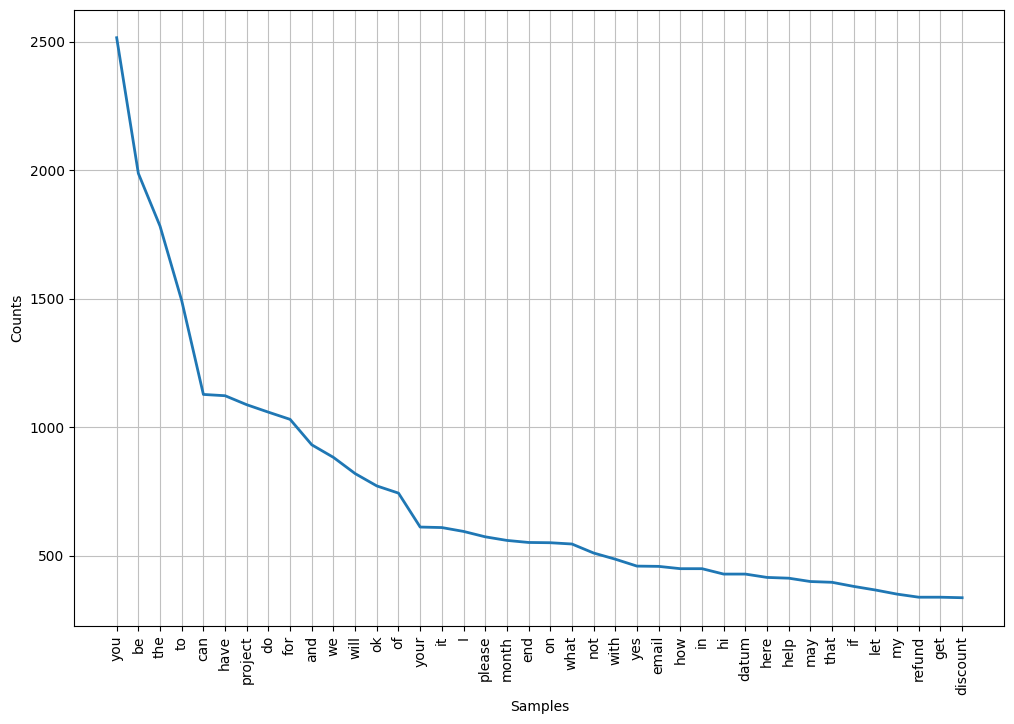

In [14]:
eda.plot_dist_curve()

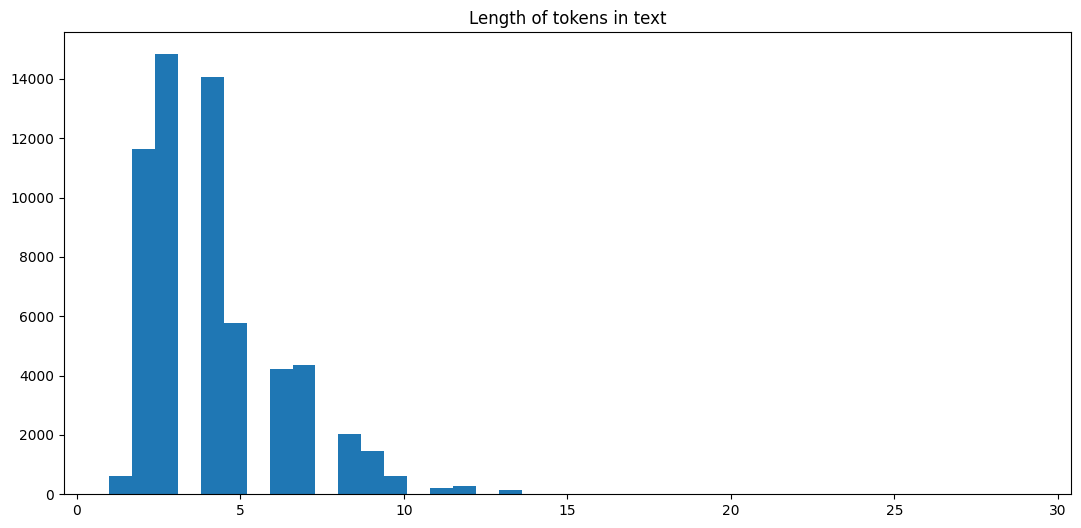

In [15]:
eda.get_token_length_visualisations()

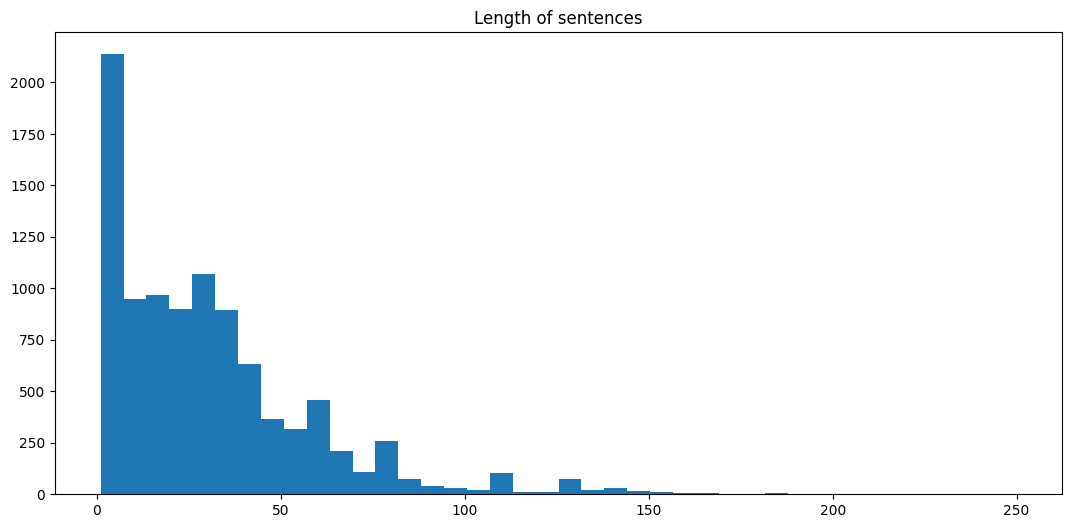

In [16]:
eda.get_sent_length_visuals()

## Cluster Intent Labels

In [17]:
class ClusterIntents:
    '''Class for clustering utterances and generating labels for clusters.'''

    def __init__(self, data, label_file, sorted_labels=False):
        '''Args:
            data (:obj:`dataframe`): Tabularised chat transcript data.
            label_file (str): Variable for path to save output file with labelled utterances.
            module_url (str): Variable for url to pretrained Universal
            Sentence Encoder model.
            sorted_labels (bool, optional): Option to sort output file by labels instead of
            by original chat order.
        '''

        self.data = data
        self.label_file = label_file

        # list of utterances
        all_intents = self.data['text'].tolist()

        # numpy array of document embeddings
        embeddings = embedder(all_intents)

        # convert embeddings array to sentence embeddings using USE
        model = ChatIntents(embeddings, 'use')

        # hyperparameter search configuration
        hspace = {
            "n_neighbors": hp.choice('n_neighbors', range(3,16)),
            "n_components": hp.choice('n_components', range(3,16)),
            "min_cluster_size": hp.choice('min_cluster_size', range(23,38)),
            "min_samples": None,
            "random_state": 42
        }

        # label number upper and lower bounds
        label_lower = 30
        label_upper = 100

        # maximum number of search runs
        max_evals = 25

        # run bayesian hyperparameter search
        model.bayesian_search(space=hspace,
                              label_lower=label_lower,
                              label_upper=label_upper,
                              max_evals=max_evals)

        # print the best model parameters found search
        model.best_params

        # hyperparameter optimized instance attribute
        self.model_final = model

        # generate summary dataframe and labeled utts dataframe
        self.df_summary, self.labeled_utts = self.model_final.apply_and_summarize_labels(data[['text']])

        # original data with appended labels data
        self.labeled_data = self._get_labeled_data()

        if sorted_labels:
            self.labeled_data = self.get_sorted_labels()

        # output csv file containing extended data input
        self._get_data_csv()
        print(f'Labelled utterances successfuly written to {label_file}')

    def get_model_best_params(self):
        '''Prints the final best parameters derived through search.'''

        return self.model_final.trials.best_trial

    def get_cluster_plot(self):
        '''Plot the clusters found from clustering.'''

        return self.model_final.plot_best_clusters()

    def get_labels_summary(self, n: int):
        '''Print n slice of labels summary.'''

        return self.df_summary.head(n)

    def get_labeled_utts(self, n: int):
        '''Print n slice of labelled utterances.'''

        return self.labeled_utts.head(n)

    def _get_labeled_data(self):
        '''Takes original data input adds label column and then removes duplicate
        utterances that have the same label.'''

        data_copy = self.data.copy()
        data_copy['label'] = self.labeled_utts['label']
        data_copy_dedup = data_copy.drop_duplicates(subset=['original_text', 'text', 'label'], keep='first')
        return data_copy_dedup

    def _get_sorted_labels(self):
        '''Sort extended data table by label.'''

        return self.labeled_data.sort_values(by=['label'])

    def _get_data_csv(self):
        '''Exports extended data to csv file.'''

        return self.labeled_data.to_csv(self.label_file)

In [18]:
cluster = ClusterIntents(data, LABEL_FILE)

  0%|          | 0/25 [00:00<?, ?trial/s, best loss=?]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  4%|▍         | 1/25 [00:53<21:35, 53.98s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



  8%|▊         | 2/25 [01:31<16:54, 44.13s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 12%|█▏        | 3/25 [02:05<14:35, 39.79s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 16%|█▌        | 4/25 [02:42<13:30, 38.57s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 20%|██        | 5/25 [03:16<12:19, 36.97s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 24%|██▍       | 6/25 [03:53<11:42, 36.99s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 28%|██▊       | 7/25 [04:18<09:52, 32.90s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 32%|███▏      | 8/25 [04:57<09:51, 34.80s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 36%|███▌      | 9/25 [05:18<08:08, 30.50s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 40%|████      | 10/25 [05:44<07:18, 29.20s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 44%|████▍     | 11/25 [06:27<07:50, 33.60s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 48%|████▊     | 12/25 [07:11<07:54, 36.51s/trial, best loss: 0.24084896954783144]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 52%|█████▏    | 13/25 [07:41<06:57, 34.77s/trial, best loss: 0.216343689121296]  

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 56%|█████▌    | 14/25 [07:58<05:21, 29.26s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 60%|██████    | 15/25 [08:20<04:30, 27.07s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 64%|██████▍   | 16/25 [08:50<04:13, 28.12s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 68%|██████▊   | 17/25 [09:27<04:05, 30.66s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 72%|███████▏  | 18/25 [09:58<03:36, 30.89s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")

/usr/local/lib/python3.10/dist-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(



 76%|███████▌  | 19/25 [10:15<02:39, 26.65s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 80%|████████  | 20/25 [10:39<02:08, 25.64s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 84%|████████▍ | 21/25 [11:00<01:38, 24.54s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 88%|████████▊ | 22/25 [11:26<01:14, 24.70s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 92%|█████████▏| 23/25 [11:45<00:46, 23.19s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



 96%|█████████▌| 24/25 [12:24<00:27, 27.80s/trial, best loss: 0.216343689121296]

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")



100%|██████████| 25/25 [12:53<00:00, 30.95s/trial, best loss: 0.19481185276325233]
best:
{'min_cluster_size': 24, 'min_samples': None, 'n_components': 9, 'n_neighbors': 10, 'random_state': 42}
label count: 78


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Labelled utterances successfuly written to /content/drive/MyDrive/code/input/unsupervised_labeled_data.csv


In [19]:
cluster.get_model_best_params()

{'state': 2,
 'tid': 24,
 'spec': None,
 'result': {'loss': 0.19481185276325233, 'label_count': 78, 'status': 'ok'},
 'misc': {'tid': 24,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'min_cluster_size': [24],
   'n_components': [24],
   'n_neighbors': [24]},
  'vals': {'min_cluster_size': [1], 'n_components': [6], 'n_neighbors': [7]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2024, 2, 6, 14, 30, 27, 134000),
 'refresh_time': datetime.datetime(2024, 2, 6, 14, 30, 56, 474000)}

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


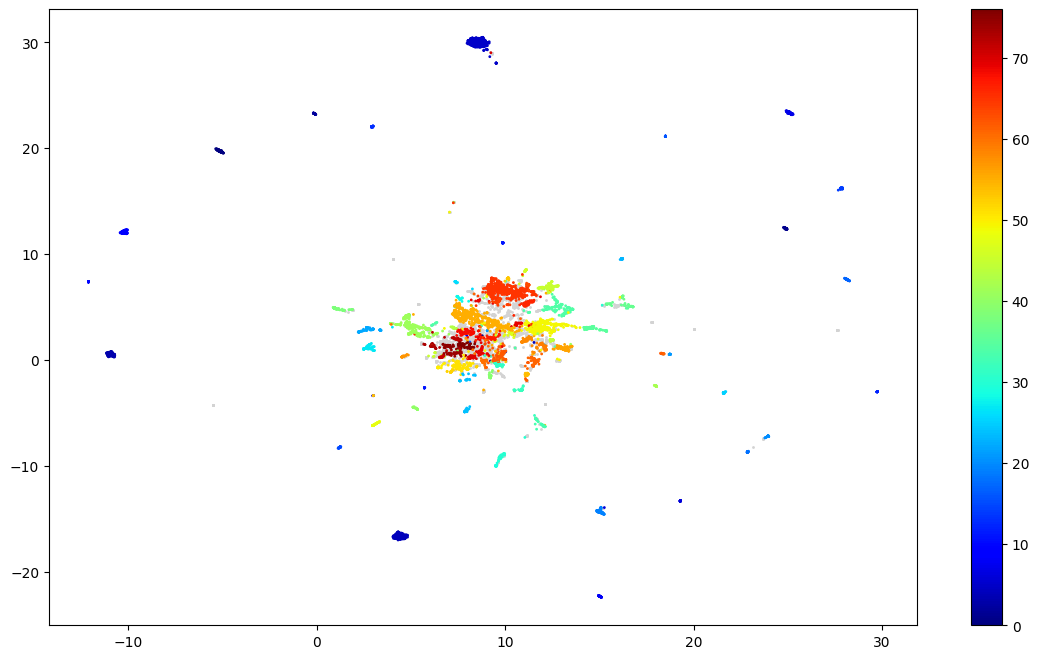

In [20]:
cluster.get_cluster_plot()

In [21]:
cluster.get_labels_summary(20)

,label_use,count,label
0,-1,1876,like_project_datum
66,65,661,want_project_datum
56,55,633,help_discount_price
6,5,572,ok_ya_coll
50,49,378,pay_subscription_month_plan
42,41,334,send_email_team
5,4,312,yes
4,3,222,hi_day
20,19,190,sure
35,34,181,provide_plan_month_tech


In [22]:
cluster.get_labeled_utts(20)

,text,label_use,label
0,hi please let I know how can help yo...,0,let_field_today_phone
1,view list of end to end machine lear...,9,learn_machine_end_view
2,solution code video tech support moc...,7,guarantee_solution_code
3,hello sure,14,hello
4,hi,3,hi_day
5,how be you,21,_weather
6,fine,-1,like_project_datum
7,great,33,great
8,how may help,16,help_help
9,wonder do you guy have charge,55,help_discount_price


## Prepare data

In [23]:
with open(INTENT_FILE, 'r') as f:
    intent_data = json.load(f)

intents = sorted(list(intent_data.keys()))

In [24]:
intent_data

{'interview_resume': {'1': ['also can you help me with resume',
   'Do you have one to one resume prep',
   'also, can i get resume guidance as well?',
   'Any interview tips and guidance for me to crack?',
   'Do i get resume tips and mock interviews aswell?',
   'and what about the interviews training',
   'how you guys choose projects to crack the interview',
   'also let me know how you can help me with interview prep'],
  '2': ['we provide resume preparation and mock interviews']},
 'live_session_mentoring': {'1': ['do u provide live session also',
   'do you ny technical guidence or session in this',
   'no live classes?',
   'will i have live mentor',
   '1 - 1 live mentoring too?',
   'or there will be any mentoring',
   'Will I get mentor who will guide me from scratch how to upload data, clean data and so on..'],
  '2': ['you will get help in customised projects in 1-1 sessions',
   'you get unlimitted sessions with experts to clariffy your queries',
   'You take help of our 

In [63]:
class PrepareData:
    '''Class for preparing data for training.'''

    def __init__(self, json_data, intents):
        '''Args:
            json_data (str): Variable for path to json intents file.
            intents (:obj: `list`): List of intents.
        '''

        # load intents data into dataframe
        self.df = pd.DataFrame.from_dict(json_data)

        self.intents = intents

        self.df_reformat = self._reformat_intents_df()
        self.df_preprocessed = self._preprocess_utts()
        df_one_hot_labels = self._encode_labels()
        self.df_concat = pd.concat([self.df_preprocessed, df_one_hot_labels], axis=1)
        self.df_train, self.df_val, self.df_test = self._get_train_val_test()
        self.train_x, self.val_x, self.test_x, self.train_y, self.val_y, self.test_y = self._get_input_output()

    def _reformat_intents_df(self):
        '''Takes data frame, removes response column
        and expands query list to individual rows with matching intent.'''

        df_T =  self.df.T.reset_index()
        df_T.columns = ["intent", "query", "response"]
        df_drop_response = df_T.drop(columns="response")
        df_drop_response.intent = df_drop_response.intent.astype('category')
        df_explode = df_drop_response.explode('query')
        return df_explode

    def _preprocess_utts(self):
        '''Passes utterances through preprocessing
        and deduplicates utterances of the same intent label.'''

        self.df_reformat['query_preprocessed'] = self.df_reformat.apply(lambda row: Utt(row['query'], query=True).parse_utt(), axis = 1)
        df_filter = self.df_reformat.dropna()
        df_dedup = df_filter.drop_duplicates(subset=['intent', 'query'], keep='first')
        return df_dedup

    def _encode_labels(self):
        '''One hot encodes labels.'''

        df_one_hot_intents = pd.get_dummies(self.df_preprocessed.intent)
        return df_one_hot_intents

    def _get_train_val_test(self):
        '''Split randomized data into train/eval/test with 80:10:10 ratio.'''

        df_train, df_val, df_test = np.split(self.df_concat.sample(frac=1, random_state=42),
                                             [int(.8*len(self.df_concat)), int(.9*len(self.df_concat))])
        return df_train, df_val, df_test

    def _get_input_output(self):
        '''Converts input and output taxt and labels to numpy arrays.'''

        train_queries_list = self.df_train['query_preprocessed'].tolist()
        val_queries_list = self.df_val['query_preprocessed'].tolist()
        test_queries_list = self.df_test['query_preprocessed'].tolist()

        train_x = np.array(train_queries_list, dtype=object)[:, np.newaxis]
        val_x = np.array(val_queries_list, dtype=object)[:, np.newaxis]
        test_x = np.array(test_queries_list, dtype=object)[:, np.newaxis]

        df_train_y = self.df_train.iloc[:,3:]
        df_val_y = self.df_val.iloc[:,3:]
        df_test_y = self.df_test.iloc[:,3:]

        train_y = df_train_y.to_numpy()
        val_y = df_val_y.to_numpy()
        test_y = df_test_y.to_numpy()

        return train_x, val_x, test_x, train_y, val_y, test_y

In [26]:
prep = PrepareData(intent_data, intents)

In [27]:
prep.df_preprocessed

,intent,query,query_preprocessed
0,interview_resume,also can you help me with resume,also can you help I with resume
0,interview_resume,Do you have one to one resume prep,do you have one to one resume prep
0,interview_resume,"also, can i get resume guidance as w...",also can get resume guidance as well
0,interview_resume,Any interview tips and guidance for ...,any interview tip and guidance for I...
0,interview_resume,Do i get resume tips and mock interv...,do get resume tip and mock interview...
...,...,...,...
39,i_get_back,right now cant make teh payment,right now can not make teh payment
39,i_get_back,I will think about it. Thanks for yo...,will think about it thank for your t...
39,i_get_back,Hey I need some time to think,hey need some time to think
39,i_get_back,okay ..will contact you tomorrow,okay will contact you tomorrow


In [28]:
train_x, val_x, test_x, train_y, val_y, test_y = prep.train_x, prep.val_x, prep.test_x, prep.train_y, prep.val_y, prep.test_y

## Train model

In [29]:
class ModelTrain:
    '''Class tuning model and then training.'''

    def __init__(self, train_x, val_x, train_y, val_y, module_url):
        '''Args:
            train_x (array): Numpy array of training utterances.
            val_x (array): Numpy array of validation utterances.
            train_y (array): Numpy array of one hot encoded training labels.
            val_y (array): Numpy array of one hot encoded validation labels.
            module_url (str): Variable for url to pretrained Universal
            Sentence Encoder model.
        '''

        self.train_x, self.val_x, self.train_y, self.val_y = train_x, val_x, train_y, val_y

        # initialise input layer with pretrained USE weights
        self.embed = hub.KerasLayer(module_url, input_shape=[], dtype=tf.string, trainable=True)

        # hyperparamter tuning
        self.tuner = keras_tuner.BayesianOptimization(
            self._build_model,
            objective="val_loss",
            max_trials=25,
            overwrite=True,
            directory="/content/drive/MyDrive/code/outputs/hp_dir",
            project_name="tune_hypermodel"
        )

        # Early stopping
        self.early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        self._tune_parameters()

        # print best hyperparameters
        best_hps = self.tuner.get_best_hyperparameters(num_trials=1)[0]

        # configure model with best hyperparameters
        self.model = self.tuner.hypermodel.build(best_hps)

        self.best_epoch = self._get_best_epoch()

        # monitor training on tensorboard
        log_dir = "log/intent_recognition/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%s")
        self.tensorboard_cb = keras.callbacks.TensorBoard(log_dir=log_dir)

        self._train()

        print('Training complete!')

        # save model
        self.model.save("/content/drive/MyDrive/code/outputs/saved_model_keras")

    def _tune_parameters(self):
        '''Performs hyperparameter tuning.'''

        self.tuner.search(
            self.train_x,
            self.train_y,
            epochs=10,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping]
        )

    def _get_best_epoch(self):
        '''Gets best epoch number for training.'''

        history = self.model.fit(
            self.train_x,
            self.train_y,
            epochs=50,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping],
            workers=4,
            use_multiprocessing=True
        )

        val_loss_per_epoch = history.history['val_loss']
        best_epoch = val_loss_per_epoch.index(max(val_loss_per_epoch)) + 1
        print(f'Best epoch: {best_epoch}')

        return best_epoch

    def _build_model(self, hp):
        '''Compile model'''

        model = tf.keras.models.Sequential()
        model.add(self.embed)
        for i in range(hp.Int("num_layers", 1, 3)):
            model.add(
                layers.Dense(
                    units=hp.Int("units", min_value=128, max_value=512, step=128),
                    activation=hp.Choice("activation", ["relu", "tanh", "sigmoid"])
                )
            )
            model.add(
                layers.Dropout(
                    hp.Choice('dropout_rate', values=[0.1, 0.3, 0.5])
                )
            )
        model.add(layers.Dense(41, activation="softmax"))
        learning_rate = hp.Choice('lr', values=[1e-2, 1e-3, 1e-4])
        model.compile(
            loss='categorical_crossentropy',
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            metrics=['categorical_accuracy']
        )
        return model

    def get_search_summary(self):
        '''Get summary of hyperparameter search space.'''

        return self.tuner.search_space_summary()

    def get_results_summary(self):
        '''Get summary of tuning results.'''

        return self.tuner.results_summary()

    def get_model_summary(self):
        '''Get summary of final model.'''

        return self.model.summary()

    def get_model_diagram(self):
        '''Get diagram of model architecture.'''

        return keras.utils.plot_model(self.model, "Model_Diagram.png", show_shapes=True)

    def _train(self):
        '''Train the model.'''

        # Train the model one final time while saving the best model.
        history = self.model.fit(
            self.train_x,
            self.train_y,
            epochs=self.best_epoch,
            validation_data=(self.val_x, self.val_y),
            callbacks=[self.early_stopping, self.tensorboard_cb],
            workers=4,
            use_multiprocessing=True
        )

        with open('/content/drive/MyDrive/code/outputs/HistoryDict', 'wb') as f:
            pickle.dump(history.history, f)

In [31]:
# train = ModelTrain()

In [32]:
# train.get_search_summary()

In [33]:
# train.get_results_summary()

In [34]:
# train.get_model_summary()

In [35]:
# train.get_model_diagram()

## Evaluate model

In [36]:
class Eval:
    '''Class for model evaluation.'''

    def __init__(self, model, td, intents, test_x, test_y):
        '''Args:
            model (str): Variable name for model path.
            td (:obj:, `dataframe`): Dataframe from prapare data object.
            intents (:obj:`list`): Ordered list of intent labels.
            test_x (array): Numpy array of test utterances.
            test_y (array): Numpy array of one hot encoded test labels.
        '''

        self.test_x = test_x
        self.test_y = test_y

        self.intents = intents

        # get column containing labels of test data
        self.df_test = td.df_test.iloc[:, 0:1]

        # get label predictions of test inputs
        predicts = model.predict(self.test_x, batch_size=32)

        # Get predicted labels that are above 0.5 probability
        self.predict_logits = predicts.argmax(axis=1)

        self.predicted_labels = [self.intents[logit] for logit in self.predict_logits]

        self.test_y_rounded = np.argmax(self.test_y, axis=1)
        self.model = model

    def get_test_loss_acc(self):
        '''Get accuracy and loss of test data.'''

        test_scores = self.model.evaluate(self.test_x, self.test_y, verbose=2)
        print("Test loss:", test_scores[0])
        print("Test accuracy:", test_scores[1])


    def get_accuracy_plot(self, history):
        '''Plot test accuracy against training accuracy.'''

        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def get_loss_plot(self, history):
        '''Plot test loss against training loss.'''

        plt.plot(history['loss'])
        plt.plot(history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper left')
        plt.show()

    def compare_predicted_intents(self):
        '''Get table of predicted vs actuals intent labels.'''

        self.df_test['predicted_intent'] = self.predicted_labels
        print(self.df_test)

    def get_fscore(self):
        '''Get f-score of predicted labels.'''

        return pd.DataFrame(classification_report(self.test_y_rounded, self.predict_logits, output_dict=True)).T

    def get_confusion_matrix(self):
        '''Get confusion matrix of predicted vs actual labels.'''

        cm = confusion_matrix(self.test_y_rounded, self.predict_logits)
        cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
        cm_display.plot()
        plt.show()

In [37]:
model = load_model(MODEL_PATH)

In [38]:
evaluate = Eval(model, prep, intents, test_x, test_y)

2/2 [==============================] - 1s 19ms/step


In [39]:
evaluate.get_test_loss_acc()

2/2 - 1s - loss: 6.8636 - accuracy: 0.2174 - 572ms/epoch - 286ms/step
Test loss: 6.863568305969238
Test accuracy: 0.21739129722118378


In [40]:
history = pickle.load(open(MODEL_HISTORY, "rb"))

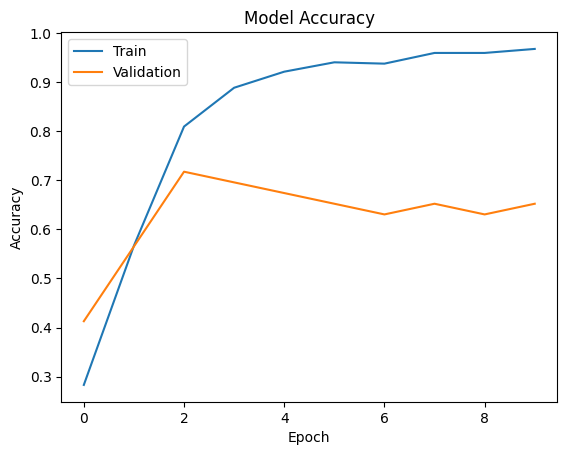

In [41]:
evaluate.get_accuracy_plot(history)

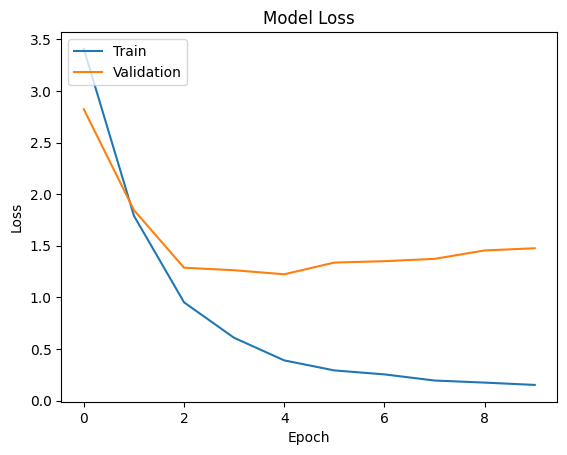

In [42]:
evaluate.get_loss_plot(history)

In [43]:
evaluate.compare_predicted_intents()

                  intent      predicted_intent
39            i_get_back               how_are
30          project_want               how_are
26              thanking              thanking
9           payment_link          offer_trials
34            give_email                annual
8               location          offer_trials
25       demo_discussion      interview_resume
26              thanking              thanking
39            i_get_back   refund_process_time
26              thanking              thanking
25       demo_discussion                  cost
10                Paypal                annual
7                  MLOPS          offer_trials
31           refund_info           refund_info
26              thanking              thanking
26              thanking              thanking
2           download_can           emi_options
30          project_want             placement
24           ProjectDemo               how_are
28      discount_student       demo_discussion
26           

In [44]:
evaluate.get_fscore()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,1.000000
5,0.000000,0.000000,0.000000,1.000000
6,0.000000,0.000000,0.000000,1.000000
7,0.000000,0.000000,0.000000,0.000000
10,0.000000,0.000000,0.000000,0.000000
11,0.000000,0.000000,0.000000,1.000000
12,0.000000,0.000000,0.000000,2.000000
13,0.000000,0.000000,0.000000,2.000000


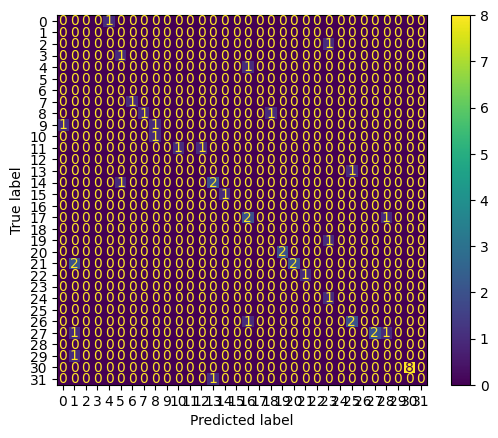

In [45]:
evaluate.get_confusion_matrix()

## Extraction

In [64]:
# extraction of the necessary data
with open('/content/drive/MyDrive/code/intents.json') as file:
    data = json.load(file)

training_sentences = []
training_labels = []
labels = []
responses = []

for intent in data['intents']:
    for pattern in intent['patterns']:
        training_sentences.append(pattern)
        training_labels.append(intent['tag'])
    responses.append(intent['responses'])

    if intent['tag'] not in labels:
        labels.append(intent['tag'])

num_classes = len(labels)

In [65]:
# transformation of tags into normalized encoding
lbl_encoder = LabelEncoder()
lbl_encoder.fit(training_labels)
training_labels = lbl_encoder.transform(training_labels)

In [66]:
# text data vectorization
# when using this class, all punctuation will be removed, transforming the texts into a sequence
# of words separated by spaces.
vocab_size = 1000
embedding_dim = 16
max_len = 20
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded_sequences = pad_sequences(sequences, truncating='post', maxlen=max_len)

In [67]:
# neural network architecture using the Keras “Sequential” model.
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 16)            16000     
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 97)                1649      
                                                                 
Total params: 18193 (71.07 KB)
Trainable params: 18193 (71.07 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

In [68]:
# neural network training
epochs = 800
history = model.fit(padded_sequences, np.array(training_labels), epochs=epochs)

Epoch 1/800
11/11 [==============================] - 1s 4ms/step - loss: 4.5726 - accuracy: 0.0093
Epoch 2/800
11/11 [==============================] - 0s 4ms/step - loss: 4.5656 - accuracy: 0.0340
Epoch 3/800
11/11 [==============================] - 0s 3ms/step - loss: 4.5578 - accuracy: 0.0617
Epoch 4/800
11/11 [==============================] - 0s 3ms/step - loss: 4.5476 - accuracy: 0.0617
Epoch 5/800
11/11 [==============================] - 0s 4ms/step - loss: 4.5335 - accuracy: 0.0617
Epoch 6/800
11/11 [==============================] - 0s 3ms/step - loss: 4.5142 - accuracy: 0.0617
Epoch 7/800
11/11 [==============================] - 0s 4ms/step - loss: 4.4864 - accuracy: 0.0617
Epoch 8/800
11/11 [==============================] - 0s 3ms/step - loss: 4.4510 - accuracy: 0.0617
Epoch 9/800
11/11 [==============================] - 0s 3ms/step - loss: 4.4069 - accuracy: 0.0617
Epoch 10/800
11/11 [==============================] - 0s 3ms/step - loss: 4.3580 - accuracy: 0.0617
Epoch 11/

In [69]:
# to save the trained model
model.save("chat_model")

# to save the fitted tokenizer
with open('/content/drive/MyDrive/code/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# to save the fitted label encoder
with open('/content/drive/MyDrive/code/label_encoder.pickle', 'wb') as ecn_file:
    pickle.dump(lbl_encoder, ecn_file, protocol=pickle.HIGHEST_PROTOCOL)

## Run chatbot

In [46]:
class Predict:
    '''Class for model inference.'''

    def __init__(self, model, intents, intent_data, utt):
        '''Args:
            model (str): Variable name for model path.
            intents (:obj:`list`): Ordered list of intent labels.
            intent_data (:obj:, `dict`): Dictionary containing intents as keys
            and and dictionaries of queries and responses as values.
            utt (str): Utterance to be used to predict intent.
        '''

        self.intent_data = intent_data

        self.intents = intents

        self.model = model

        # instantiate Utt object
        parsed_utt = Utt(utt, query=True)

        # preprocess utterance
        self.utt = parsed_utt.parse_utt()

        if self.utt:
            self.predicted_intent = self._predict_intent()

            if not self.predicted_intent:
                self.response = "Sorry, I didn't understand that. Please can you rephrase your message."
            else:
                self.response = self._get_response()
        else:
            self.response = "Sorry, I didn't understand that. Please can you rephrase your message."

    def _predict_intent(self):
        '''Given utterance, predicts intent label.'''

        query = np.array([self.utt], dtype=object)
        predict = self.model.predict(query, batch_size=32, verbose=0)
        predict_logit = predict.argmax(axis=1)
        predicted_label = self.intents[predict_logit[0]]
        if predicted_label:
            return predicted_label
        return None

    def _get_response(self):
        '''Given label, generates random response from list of available responses.'''

        response_list = self.intent_data[self.predicted_intent]['2']
        return random.choice(response_list)

In [ ]:
# bot_name = "ChatBot"
# print("How may we help you? (type 'quit' to exit)")
# while True:
#     sentence = input("You: ")
#     if sentence == "quit":
#         break

#     predict = Predict(model, intents, intent_data, sentence)
#     print(f"{bot_name}: {predict.response}")

In [70]:
def chat():
    # load trained model
    model = keras.models.load_model('chat_model')

    # load tokenizer object
    with open('/content/drive/MyDrive/code/tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    # load label encoder object
    with open('/content/drive/MyDrive/code/label_encoder.pickle', 'rb') as enc:
        lbl_encoder = pickle.load(enc)

    # parameters
    max_len = 20

    while True:
        print(Fore.LIGHTBLUE_EX + "User: " + Style.RESET_ALL, end="")
        inp = input()
        if inp.lower() == "quit":
            break

        result = model.predict(keras.preprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences([inp]),
                                             truncating='post', maxlen=max_len))
        tag = lbl_encoder.inverse_transform([np.argmax(result)])

        for i in data['intents']:
            if i['tag'] == tag:
                print(Fore.GREEN + "ChatBot:" + Style.RESET_ALL , np.random.choice(i['responses']))

print(Fore.YELLOW + "Start messaging with the bot (type quit to stop)!" + Style.RESET_ALL)
chat()

Start messaging with the bot (type quit to stop)!
User: Hello
1/1 [==============================] - 0s 67ms/step
ChatBot: Hola human, how can I help?
User: What is your favorite programming language
1/1 [==============================] - 0s 31ms/step
ChatBot:  Python is the best language for creating chat robots.
User: Tell me some gossip
1/1 [==============================] - 0s 21ms/step
ChatBot: Mike said he launched his browser and entered his name into the little slot when I asked him to.
User: What do you call me?
1/1 [==============================] - 0s 21ms/step
ChatBot: Your name is  <HUMAN>, how can I help you?
User: Thank You
1/1 [==============================] - 0s 21ms/step
ChatBot: Any time!
User: See you later
1/1 [==============================] - 0s 19ms/step
ChatBot: Have a nice day
User: quit
